### Importing Libs

In [2]:
# Importing Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_theme(style="darkgrid", rc={'figure.figsize':(16,10)})

### Creating DataFrames

Inicialmente, serão criados os datasets com os dados disponibilizados pela Olist:

In [5]:
# Defining datasets paths

CUSTOMERS_PATH = r"datasets/olist_customers_dataset.csv"
GEOLOCATION_PATH = r"datasets/olist_geolocation_dataset.csv"
ORDER_ITEM_PATH = r"datasets/olist_order_items_dataset.csv"
ORDER_PAYMENTS_PATH = r"datasets/olist_order_payments_dataset.csv"
ORDER_REVIEWS_PATH = r"datasets/olist_order_reviews_dataset.csv"
ORDERS_PATH = r"datasets/olist_orders_dataset.csv"
PRODUCTS_PATH = r"datasets/olist_products_dataset.csv"
SELLERS_PATH = r"datasets/olist_sellers_dataset.csv"
PROD_CATEG_PATH = r"datasets/product_category_name_translation.csv"

In [6]:
# DataFrames

df_customers = pd.read_csv(CUSTOMERS_PATH)
df_geoloc = pd.read_csv(GEOLOCATION_PATH)
df_order_item = pd.read_csv(ORDER_ITEM_PATH)
df_order_pay = pd.read_csv(ORDER_PAYMENTS_PATH)
df_order_rev = pd.read_csv(ORDER_REVIEWS_PATH)
df_orders = pd.read_csv(ORDERS_PATH)
df_product = pd.read_csv(PRODUCTS_PATH)
df_seller = pd.read_csv(SELLERS_PATH)
df_prod_cat = pd.read_csv(PROD_CATEG_PATH)

A partir dos DataFrames, será obtido um DataFrame utilizado para o EDA através do método `merge`:

In [8]:
# Merging DataFrames

# Merge Customer ID + Order ID
df_customer_orders = pd.merge(df_customers, df_orders, on='customer_id')

# Merge Customer ID + Order ID + Seller ID
df_customer_orders_seller = pd.merge(df_customer_orders, df_order_item, on='order_id')

# Merge Customer ID + Order ID + Seller ID + State Seller
df_cust_ord_sel_state = pd.merge(df_customer_orders_seller, df_seller, on='seller_id')

# Merge Customer ID + Order ID + Seller ID + State Seller + Paymen Type
df_cust_ord_sel_state = pd.merge(df_cust_ord_sel_state, df_order_pay, on='order_id')

# Merge Customer ID + Order ID + Seller ID + State Seller + paymenttype + Produt Category
df_eda = pd.merge(df_cust_ord_sel_state, df_product, on='product_id')

## Data Cleaning and Exploration

Abaixo, serão visualizadas as features que obtemos por meio do método `info()`, assim como os tipos:

In [11]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117601 non-null  object 
 1   customer_unique_id             117601 non-null  object 
 2   customer_zip_code_prefix       117601 non-null  int64  
 3   customer_city                  117601 non-null  object 
 4   customer_state                 117601 non-null  object 
 5   order_id                       117601 non-null  object 
 6   order_status                   117601 non-null  object 
 7   order_purchase_timestamp       117601 non-null  object 
 8   order_approved_at              117586 non-null  object 
 9   order_delivered_carrier_date   116356 non-null  object 
 10  order_delivered_customer_date  115034 non-null  object 
 11  order_estimated_delivery_date  117601 non-null  object 
 12  order_item_id                 

Existem 6 atributos referentes a datas,e terão seus tpos covertidos de `object` para `datetime64`, facilitando operações posterirores envolvendo tempo e datas:

In [15]:
df_eda['order_purchase_timestamp'] = pd.to_datetime(df_eda['order_purchase_timestamp'])
df_eda['order_approved_at'] = pd.to_datetime(df_eda['order_approved_at'])
df_eda['order_delivered_carrier_date'] = pd.to_datetime(df_eda['order_delivered_carrier_date'])
df_eda['order_delivered_customer_date'] = pd.to_datetime(df_eda['order_delivered_customer_date'])
df_eda['order_estimated_delivery_date'] = pd.to_datetime(df_eda['order_estimated_delivery_date'])
df_eda['shipping_limit_date'] = pd.to_datetime(df_eda['shipping_limit_date'])

Serão então removidas as features que não serão utilizadas nas análises, e adicionadas features a respeito de meses e anos:

In [17]:
df_eda['month_order'] = df_eda['order_purchase_timestamp'].dt.strftime("%B")
df_eda['month_order_n'] = df_eda['order_purchase_timestamp'].dt.strftime("%m")
df_eda['year_order'] = df_eda['order_purchase_timestamp'].dt.strftime("%Y")

df_eda.drop(['product_name_lenght', 'product_description_lenght',
             'product_photos_qty', 'product_weight_g',
             'product_length_cm', 'product_height_cm',
             'product_width_cm'], axis=1, inplace=True)

Após isso, veremos quantos valores nulos temos em cada feature:

In [19]:
df_eda.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name            1698
month_order 

Boa partedos valores nulos encontrados são relativos aos tempos de entrega do produto.

Em uma primeira tentativa de filtrar isso, iremos ver como se comporta os valores da feature `order_status`, informando se o produto foi ou não entregue:

In [21]:
df_status = df_eda['order_status'].value_counts().reset_index() # Count values of each status and create a new DataFrame
df_status.columns = ["order_status", "count_status"] # Rename Columns
df_status['pct'] = round((100*df_status["count_status"]/df_status["count_status"].sum()),3).astype(str) + '%' # Add new column with percentages of status
df_status.sort_values("count_status", ascending=False, inplace = True)
df_status

order_status  count_status      pct
0    delivered        115035  97.818%
1      shipped          1244   1.058%
2     canceled           566   0.481%
3   processing           375   0.319%
4     invoiced           371   0.315%
5  unavailable             7   0.006%
6     approved             3   0.003%

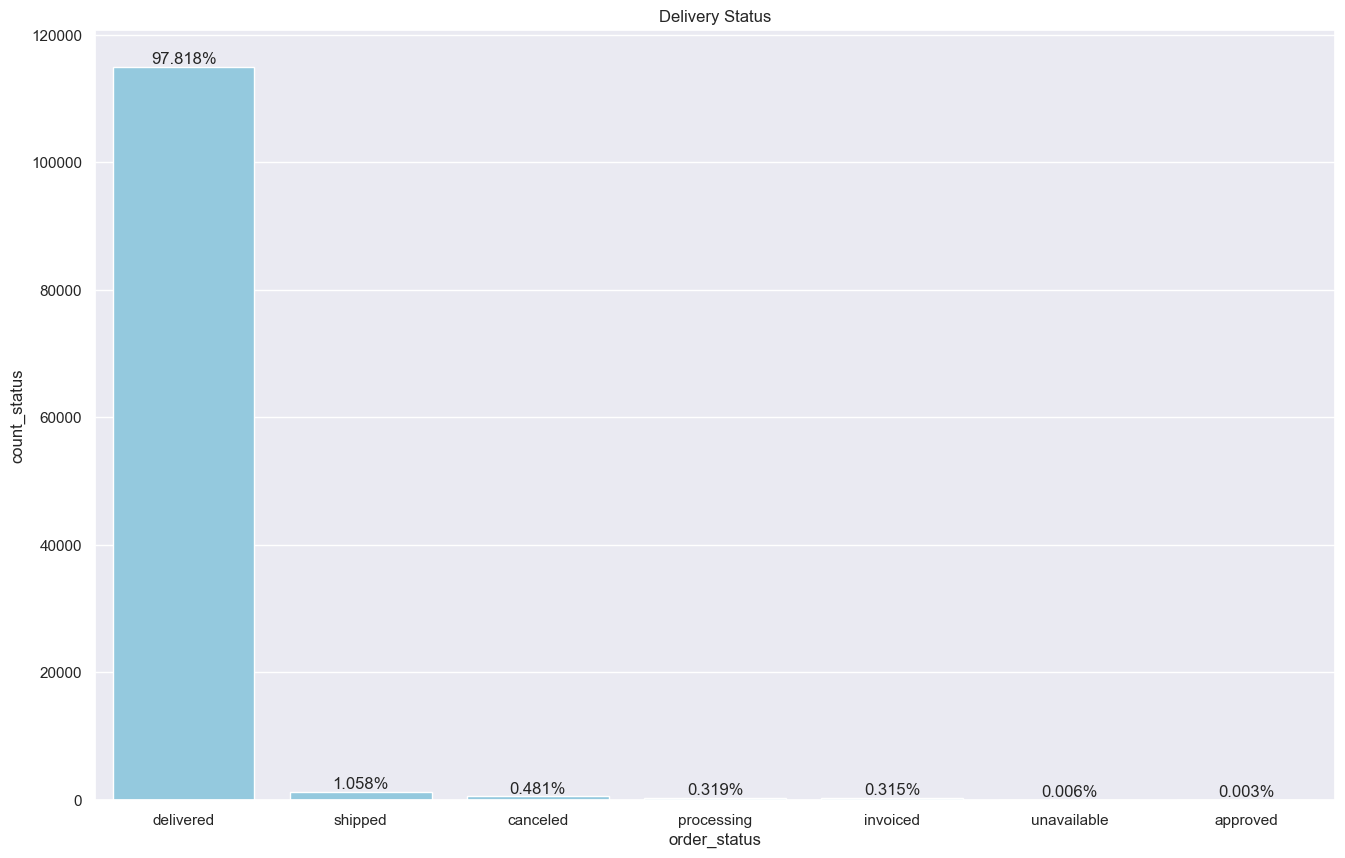

In [23]:
ax = sns.barplot(data = df_status, y='count_status', x="order_status", errorbar=None, color='skyblue')
bars = ax.containers[0]
ax.bar_label(bars, labels = df_status["pct"])
ax.set_title('Delivery Status');

Observamos então, que mais de 97% dos pedidos obtiveram o status `delivered`, ou seja, foram corretaemntes entregues. Então, para as análises que iremos fazer agora, utilizaremos apenas os quais foram entregues, ou seja, `order_status = delivered`

In [32]:
df_delivered = df_eda[df_eda['order_status']== 'delivered']
df_delivered.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ...      seller_city  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...  itaquaquecetuba   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...           itajai   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...  itaquaquecetuba   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...  itaquaquecetuba   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...         ibitinga   

  seller_state  payment_sequential payment_type payment_installments  \
0           SP                   1  credit_card                    2   
1           SC                   1  credit_card                    8   
2           SP                   1  credit_card                    7   
3           SP                   1  credit_card                    1   
4           SP                   1  credit_card                    8   

  payment_value  product_category_name  month_order  month_order_n year_order  
0        146.87      moveis_escritorio          May             05       2017  
1        335.48  utilidades_domesticas      January             01       2018  
2        157.73      moveis_escritorio          May             05       2018  
3        173.30      moveis_escritorio        March             03       2018  
4        252.25          casa_conforto         July             07       2018  

[5 rows x 29 columns]

Novamente, iremos ver quantos valores nulos temos:

In [35]:
df_delivered.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name            1628
month_order 

In [37]:
df_delivered.shape

(115035, 29)

Como faremos uam análise sobre os tempos de entrega, serão removidos os valores nulos correspondentes a isso. Quanto as valores nulos a respeito da categoria do produto (`product_category_name`), estes não irão causar problemas às análises posteriores, e por isso não serão removidos:

In [40]:
df_delivered = df_delivered.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'])

In [42]:
df_delivered.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date       0
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name            1627
month_order 

In [44]:
df_delivered.shape

(115011, 29)

Antes de iniciarmos nossa análise, é interessante ver o primeiro e último momenot que foram feitos pedidos:

In [47]:
min_order = df_eda['order_purchase_timestamp'].min()
max_order = df_eda['order_purchase_timestamp'].max()

print("The first order was made at {} and the last one was made at {}".format(min_order, max_order))

The first order was made at 2016-09-04 21:15:19 and the last one was made at 2018-09-03 09:06:57


# EDA

### Estados que mais venderam (n vendas) (conferir se isso não é o número de vendedores apenas.) Isso é o número de vendas

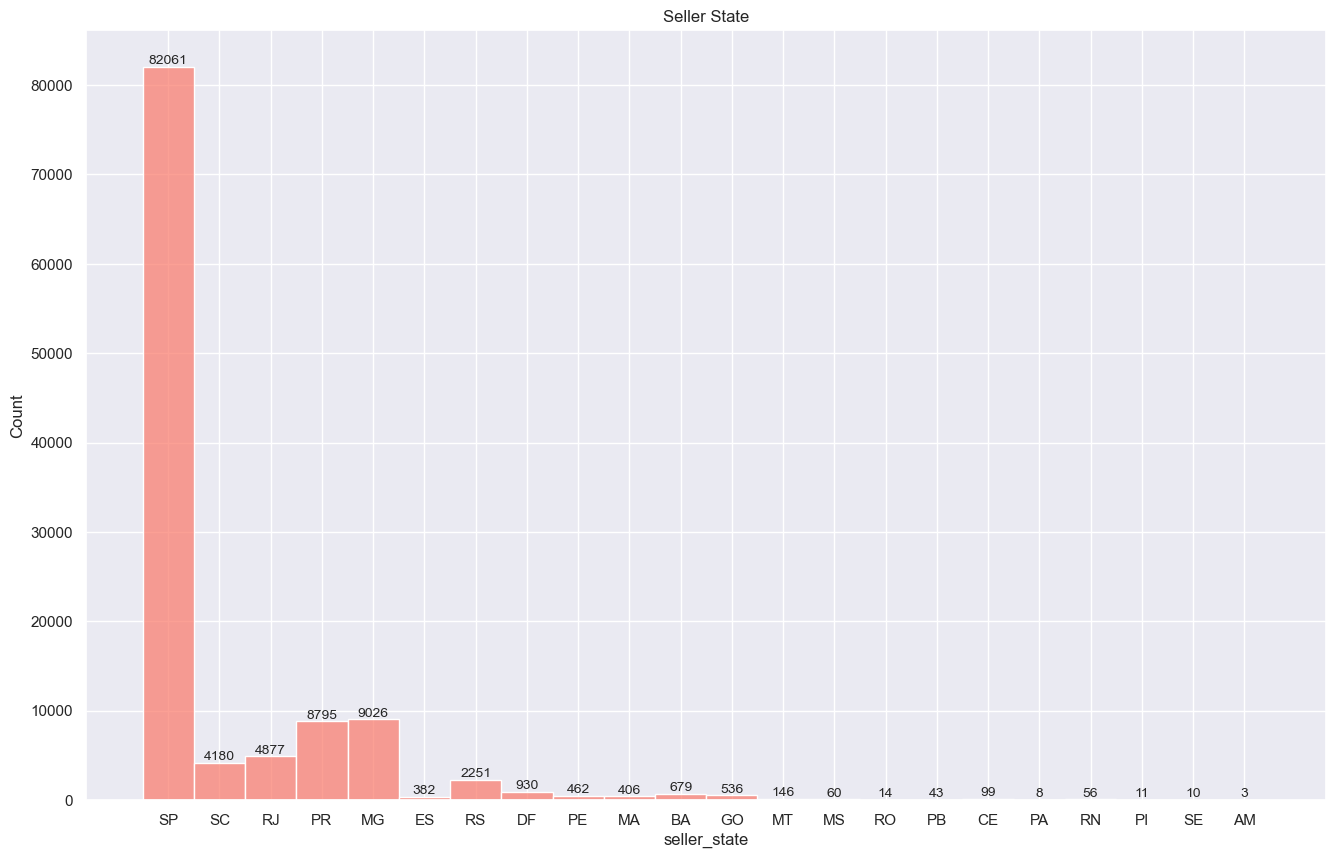

In [32]:
ax = sns.histplot(df_delivered['seller_state'], kde=False, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set(title='Seller State');

### Estados que mais compraram (n compras) ou Distribuição de Compras por Estado

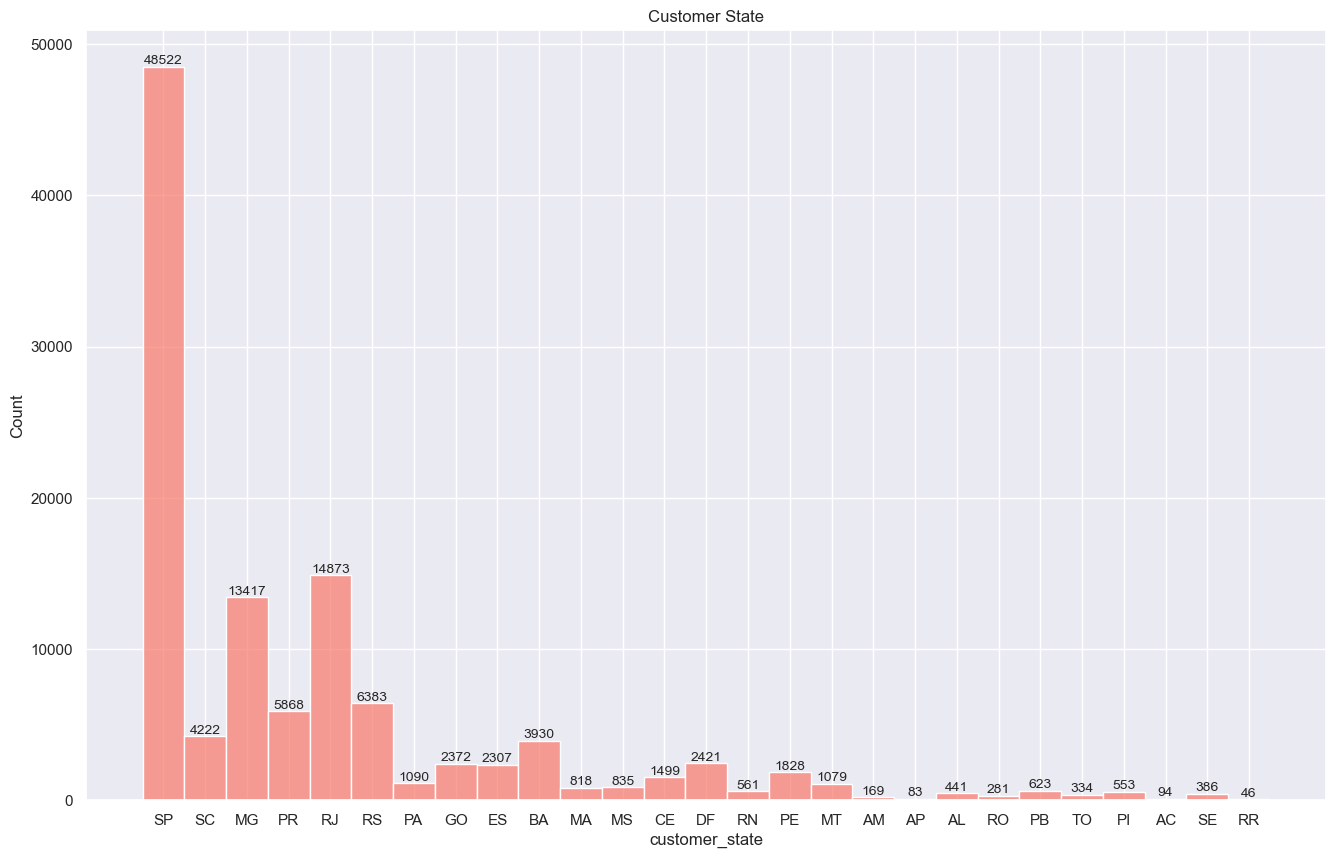

In [38]:
ax = sns.histplot(df_delivered['customer_state'], kde=False, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Customer State');

### Estados com mais clientes (usar customer unique ID)

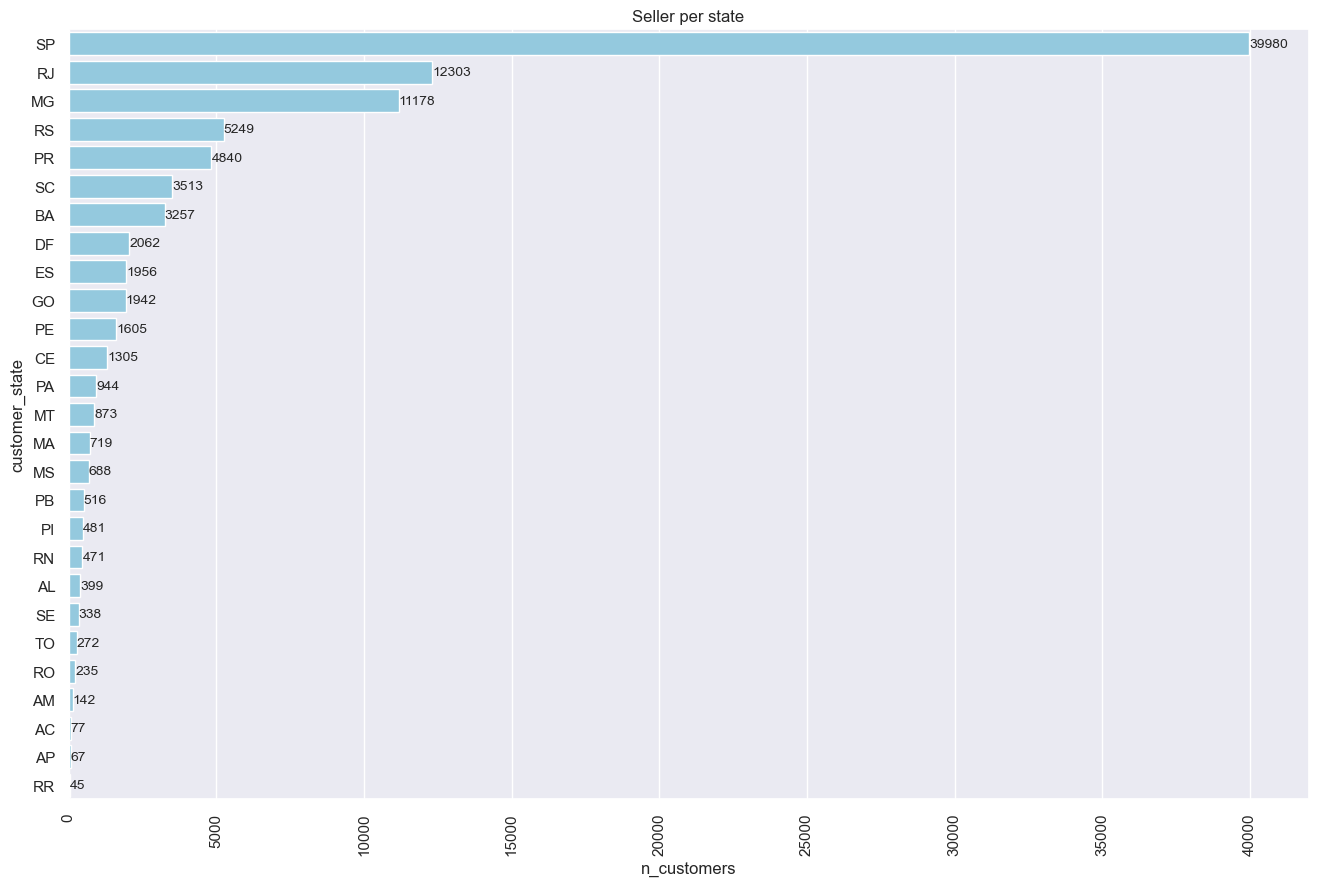

In [95]:
seller_per_state = df_eda.groupby("customer_state")["customer_unique_id"].nunique().reset_index()
seller_per_state.columns = ["customer_state", "n_customers"]
seller_per_state.sort_values("n_customers", ascending=False, inplace = True)

ax = sns.barplot(data = seller_per_state, y='customer_state', x="n_customers", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.tick_params(axis='x', rotation=90)
ax.set_title('Seller per state');

In [91]:
df_eda.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'product_category_name',
 'month_order',
 'year_order']

### Estados com mais vendedores (unique + seller ID)

### Dinheiro gasto em vendas em cada estado (Valores vendidos $)

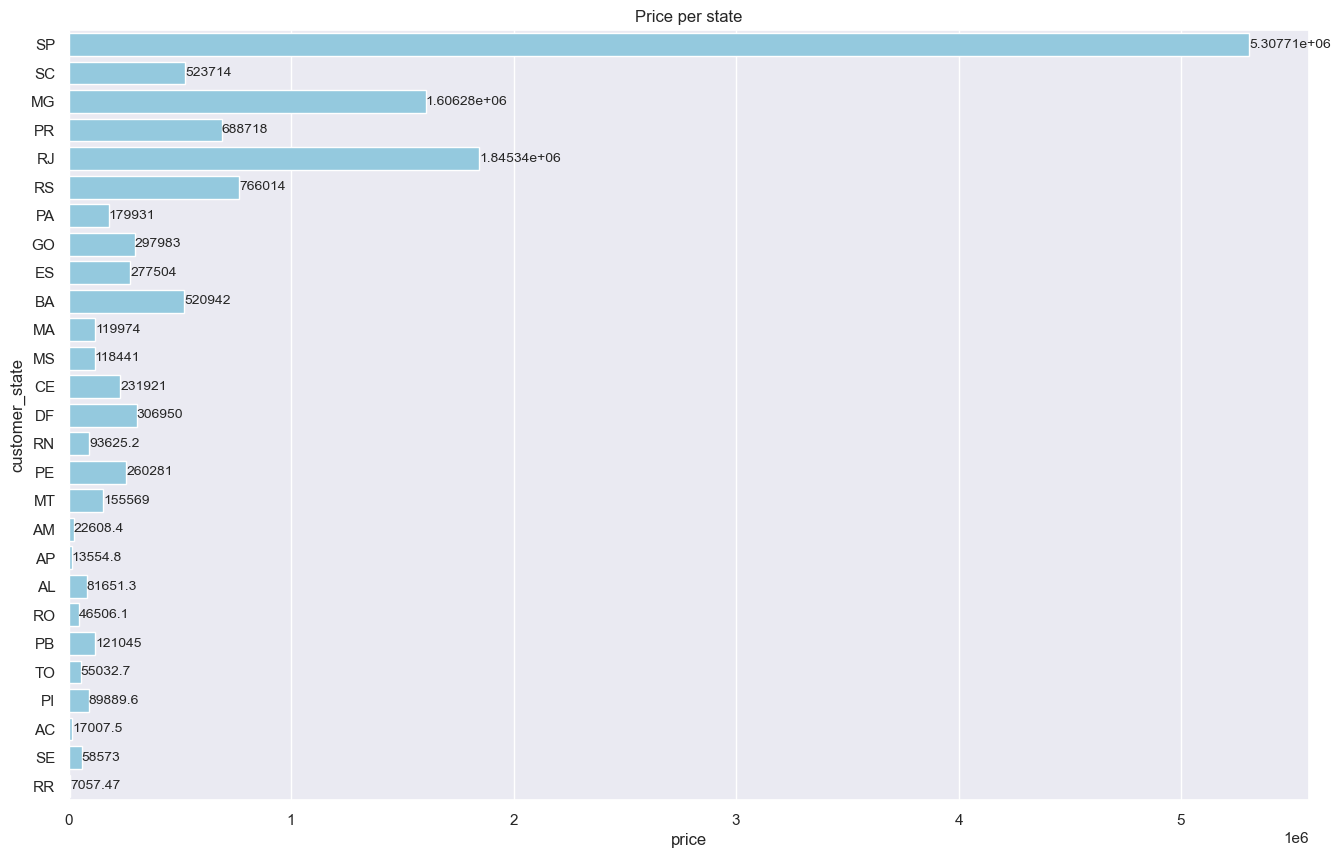

In [41]:
ax = sns.barplot(df_delivered, y="customer_state", x="price", estimator="sum", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

### Dinheiro arrecadado em vendas de cada estado (Valores comprados $)

### N Custoemr per State Estados com mais clientes (usar customer unique ID) (corrigir oq tem aqui pra unique id)

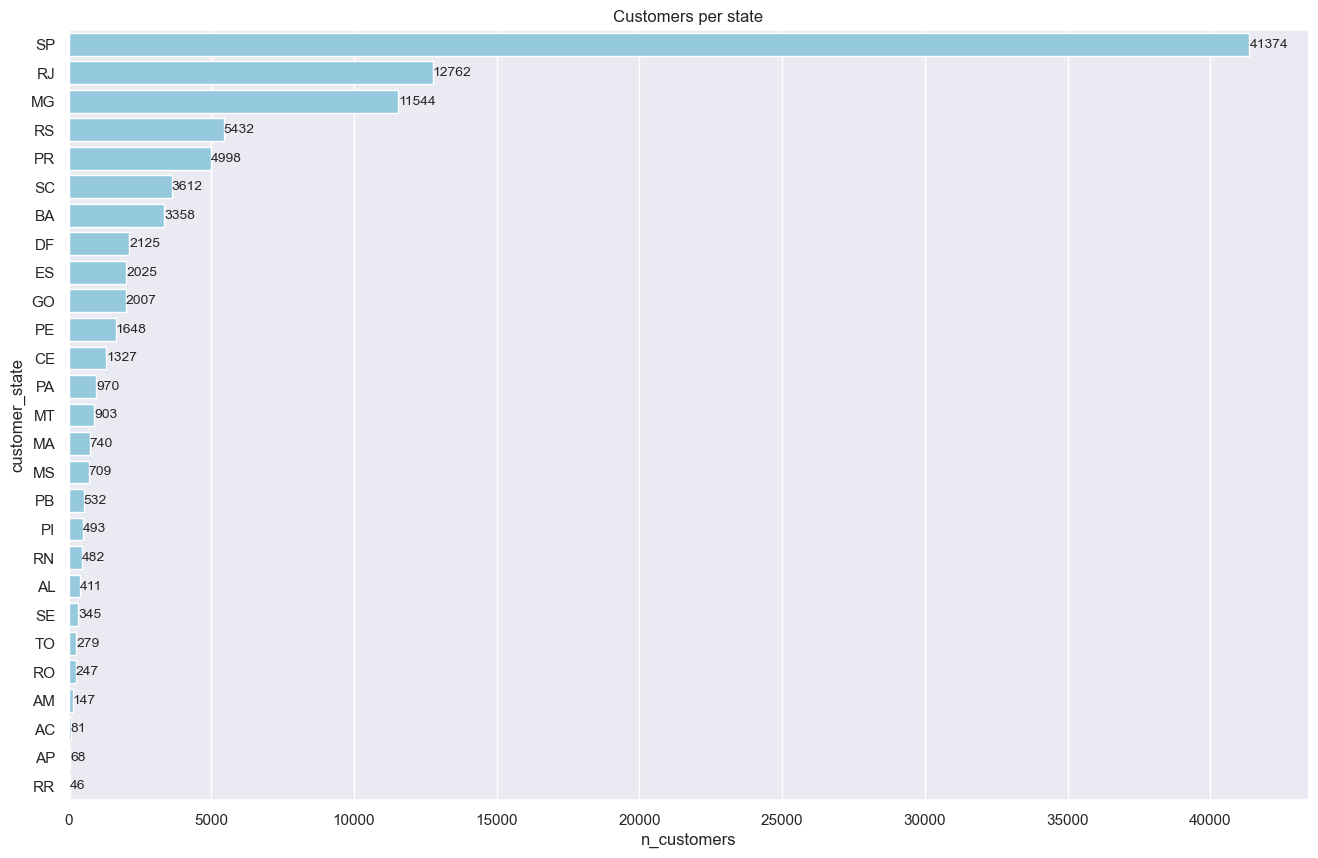

In [56]:
customers_per_state = df_eda.groupby("customer_state")["customer_id"].nunique().reset_index()
customers_per_state.columns = ["customer_state", "n_customers"]
customers_per_state.sort_values("n_customers", ascending=False, inplace = True)

ax = sns.barplot(data = customers_per_state, y='customer_state', x="n_customers", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
#ax.tick_params(axis='x', rotation=90)
ax.set_title('Customers per state');

### N Seller per State Estados com mais vendedores (unique + seller ID)

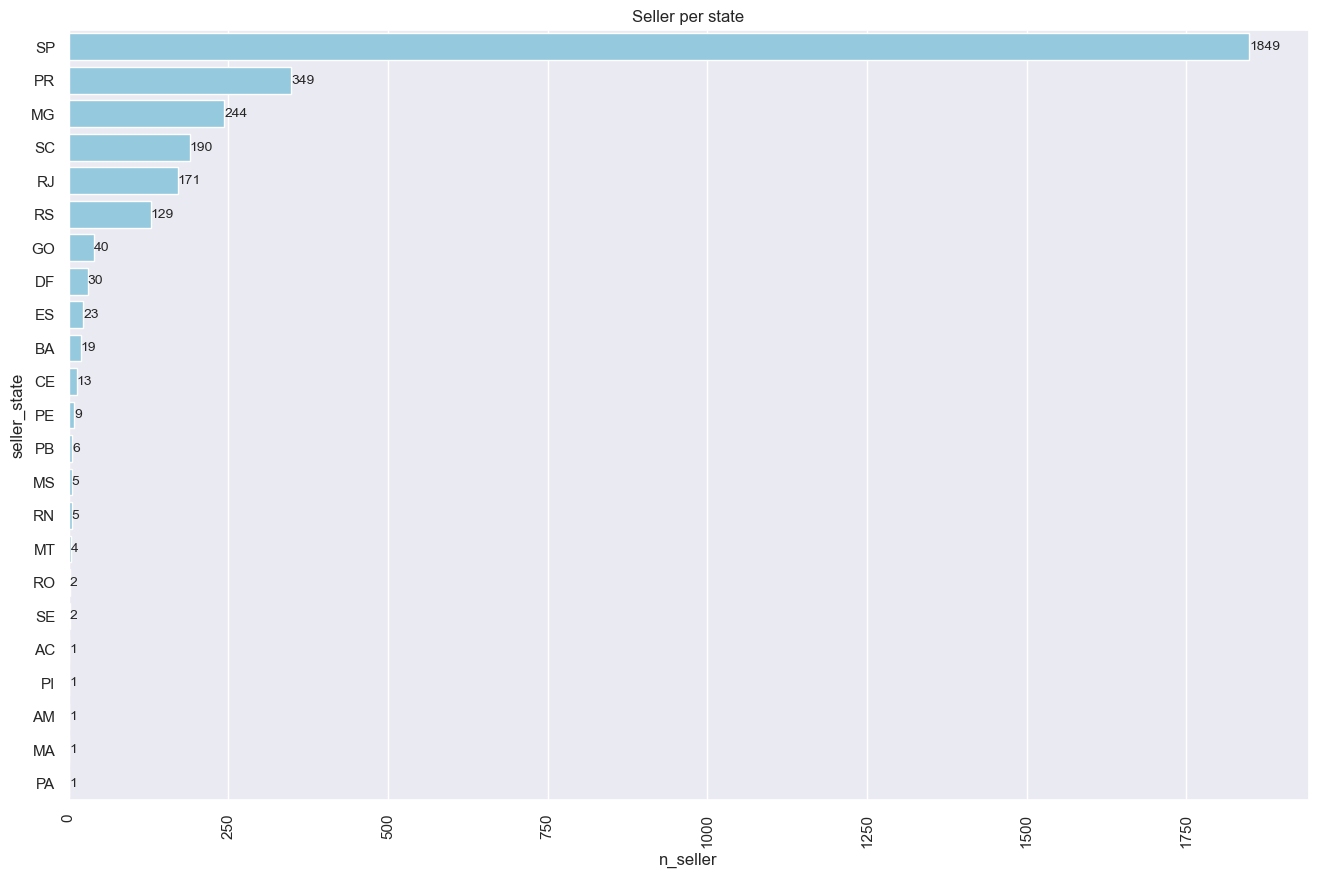

In [58]:
seller_per_state = df_eda.groupby("seller_state")["seller_id"].nunique().reset_index()
seller_per_state.columns = ["seller_state", "n_seller"]
seller_per_state.sort_values("n_seller", ascending=False, inplace = True)

ax = sns.barplot(data = seller_per_state, y='seller_state', x="n_seller", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.tick_params(axis='x', rotation=90)
ax.set_title('Seller per state');

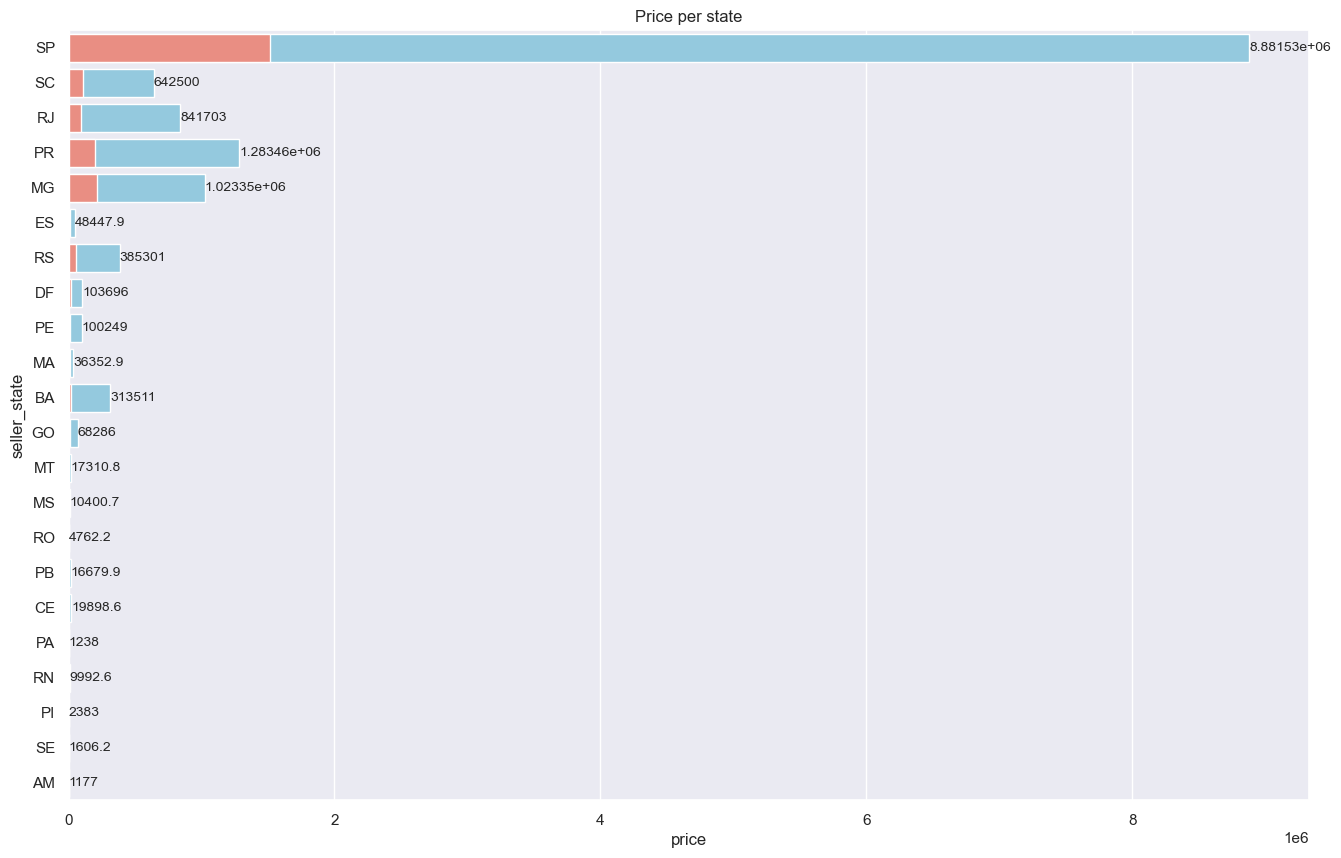

In [190]:
ax = sns.barplot(df_delivered, y="seller_state", x="price", estimator="sum", errorbar=None, color='skyblue')
ax1 = sns.barplot(df_delivered, y="seller_state", x="freight_value", estimator="sum", errorbar=None, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
#ax1.bar_label(ax1.containers[1], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

Já feito n o

### Estados que mais gastaram com frete e que mais gastaram com frete em média (Pedir sugestão de como mostrar isso em uma única figura no chat GPT)

In [68]:
df_freight_state = df_eda.groupby(['customer_state']).agg(sum_price = ('freight_value', 'sum'), mean_price = ('freight_value', 'mean')).reset_index()
df_freight_state.sort_values(by=['sum_price'], ascending = False, inplace = True)
df_freight_state['mean_price'] = df_freight_state['mean_price'].round(2)
df_freight_state

customer_state  sum_price  mean_price
25             SP  753351.18       15.20
18             RJ  323413.95       21.10
10             MG  281301.31       20.63
22             RS  141579.69       21.83
17             PR  122669.69       20.58
4              BA  106538.62       26.32
23             SC   92216.36       21.44
15             PE   61923.56       32.78
8              GO   55237.53       22.73
6              DF   52118.84       21.08
7              ES   51392.57       21.98
5              CE   50350.54       32.46
13             PA   39881.05       35.74
12             MT   32592.32       28.97
9              MA   32290.33       38.26
14             PB   27641.72       43.26
16             PI   22480.64       39.23
19             RN   20074.28       35.28
11             MS   19739.44       23.42
1              AL   16368.65       35.74
24             SE   14541.29       36.63
26             TO   13450.60       39.68
20             RO   11717.47       40.97
2              AM    5656.54       33.08
0              AC    3802.06       40.02
3              AP    2863.09       34.08
21             RR    2235.19       42.98

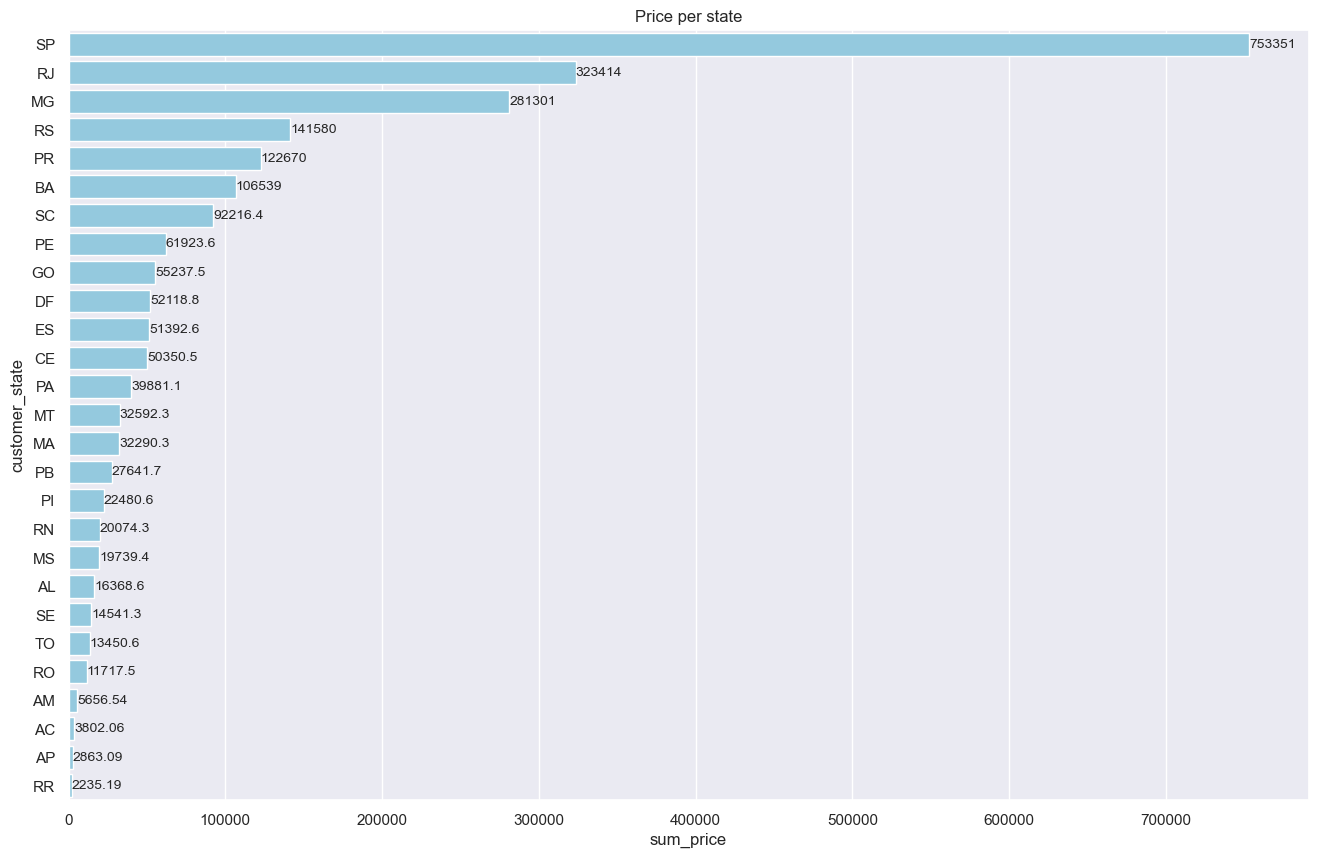

In [70]:
ax = sns.barplot(df_freight_state, y="customer_state", x="sum_price", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); 
ax.set_title('Price per state');

In [72]:
df_freight_state.sort_values(by=['mean_price'], ascending = False, inplace = True)
df_freight_state

customer_state  sum_price  mean_price
14             PB   27641.72       43.26
21             RR    2235.19       42.98
20             RO   11717.47       40.97
0              AC    3802.06       40.02
26             TO   13450.60       39.68
16             PI   22480.64       39.23
9              MA   32290.33       38.26
24             SE   14541.29       36.63
1              AL   16368.65       35.74
13             PA   39881.05       35.74
19             RN   20074.28       35.28
3              AP    2863.09       34.08
2              AM    5656.54       33.08
15             PE   61923.56       32.78
5              CE   50350.54       32.46
12             MT   32592.32       28.97
4              BA  106538.62       26.32
11             MS   19739.44       23.42
8              GO   55237.53       22.73
7              ES   51392.57       21.98
22             RS  141579.69       21.83
23             SC   92216.36       21.44
18             RJ  323413.95       21.10
6              DF   52118.84       21.08
10             MG  281301.31       20.63
17             PR  122669.69       20.58
25             SP  753351.18       15.20

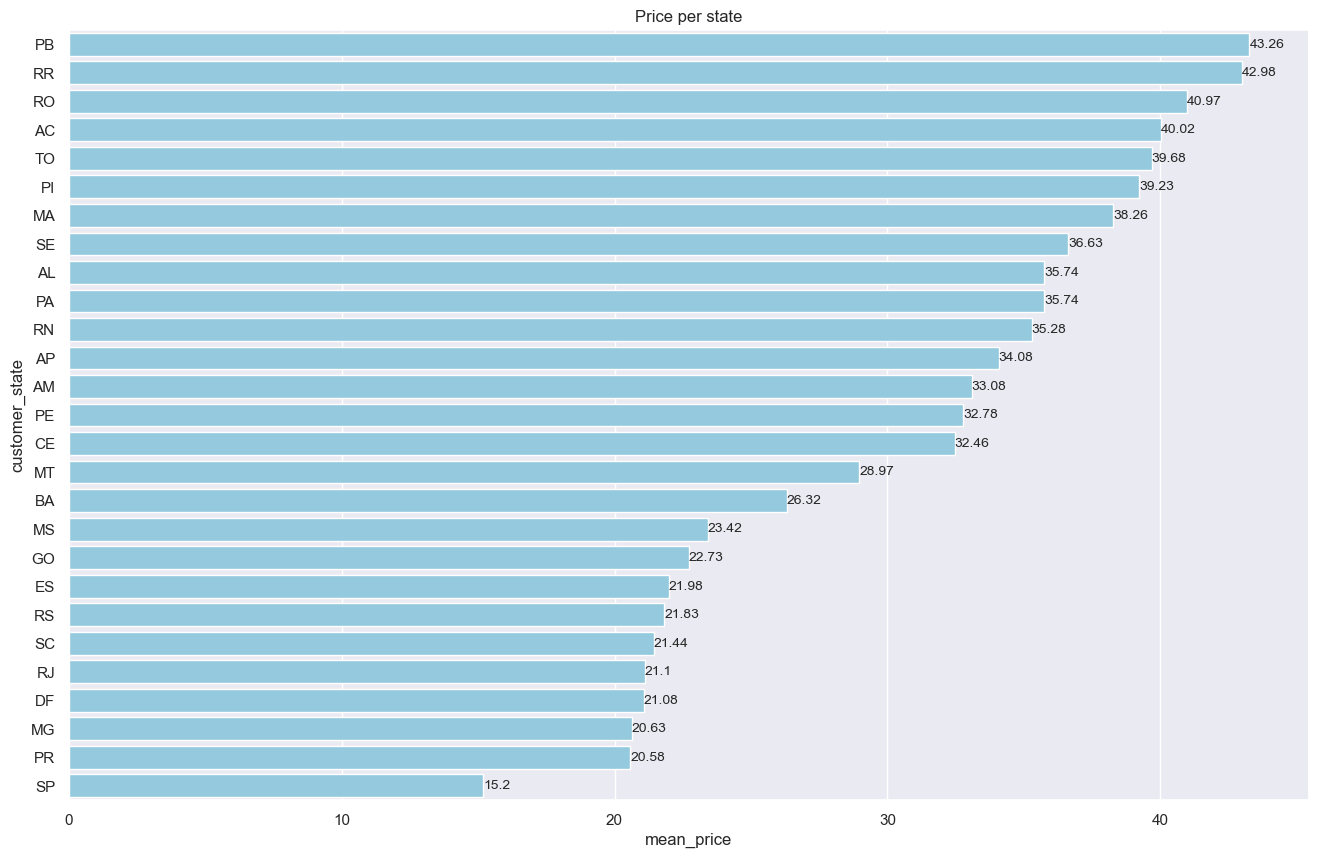

In [74]:
ax = sns.barplot(df_freight_state, y="customer_state", x="mean_price", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); 
ax.set_title('Price per state');

## Payment Type

### Forma de pagamento (piechart)

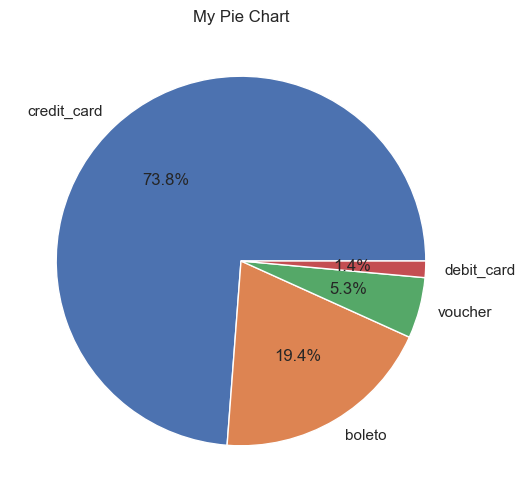

In [37]:
plt.figure(figsize=(6,6))
plt.pie(df_delivered['payment_type'].value_counts(), labels=df_delivered['payment_type'].value_counts().index, autopct='%1.1f%%')
plt.title('My Pie Chart')
plt.show()

In [48]:
df_pay = df_delivered["payment_type"].value_counts().reset_index()
df_pay

payment_type  count
0  credit_card  84896
1       boleto  22362
2      voucher   6123
3   debit_card   1654

In [60]:
import plotly.express as px
#df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
#df.loc[df['pop'] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
fig = px.pie(df_pay, values='count', names='payment_type', title='Population of European continent')
fig.show()

## Analise de categorias de produtos

### Produtos mais vendidos (barplot) -> Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight)

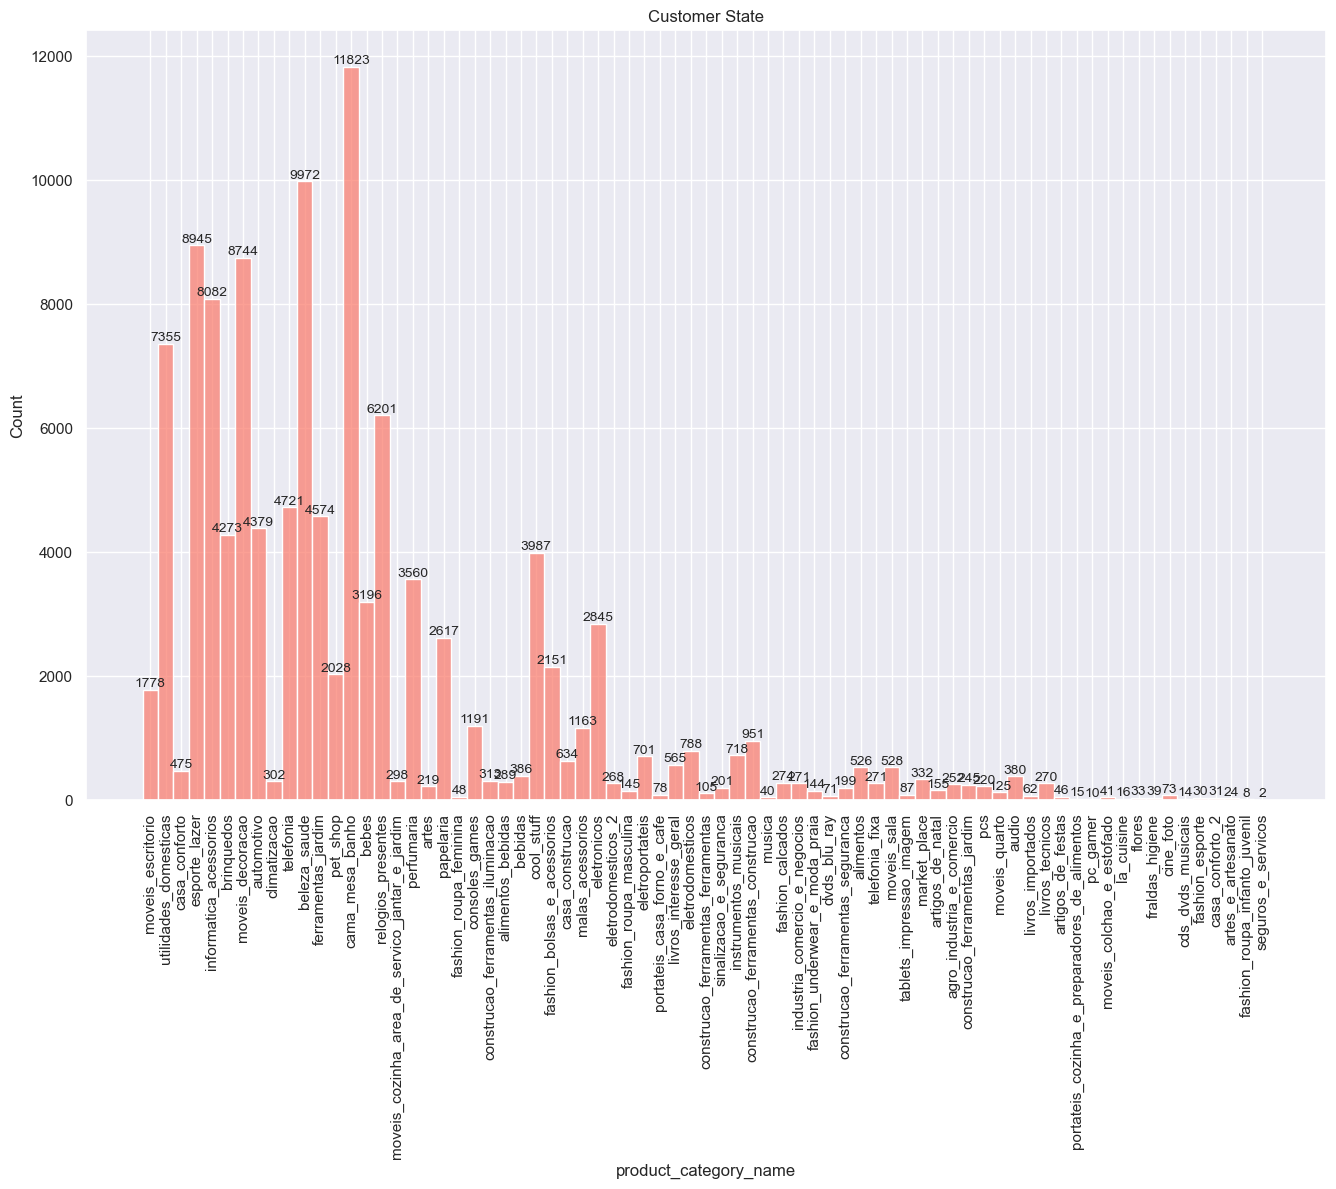

In [54]:
ax = sns.histplot(df_eda['product_category_name'], kde=False, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.tick_params(axis='x', rotation=90)
ax.set_title('Customer State');

In [ ]:
list(df_cust_ord_sel_state.columns)

In [ ]:
df_cust_ord_sel_state.head()

### Produtos mais caros (barplot) -> Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight)

In [158]:
df_prod_price = df_eda.groupby(['product_id']).agg(price_prod = ('price', 'sum'), n_prod = ('product_id', 'count')).reset_index()
df_prod_price.sort_values(by=['n_prod'], ascending = False)

product_id  price_prod  n_prod
22112  aca2eb7d00ea1a7b8ebd4e68314663af    38248.20     536
19742  99a4788cb24856965c36a24e339b6058    46308.96     525
8613   422879e10f46682990de24d770e7f83d    27694.82     505
7364   389d119b48cf3043d311335e499d9c6b    22181.19     406
7079   368c6c730842d78016ad823897a372db    21427.40     395
...                                 ...         ...     ...
14218  6e110609c2314bbd56666eb2cdb464b3       85.99       1
14213  6dffbeaccacce13f3812c3cfea13ad7b      170.90       1
14212  6dff489dd40cf8c8575c6ac85b080f04       69.90       1
14211  6dfe5ffea29ecbbe138a4066b5ebec9b       79.90       1
32950  fffe9eeff12fcbd74a2f2b007dde0c58      249.99       1

[32951 rows x 3 columns]

In [162]:
df_prod_price = df_prod_price.sort_values(by=['price_prod'], ascending = False)
df_prod_price

product_id  price_prod  n_prod
24086  bb50f2e236e5eea0100680137654686c    68485.00     209
27613  d6160fb7873f184099d9bc95e30376af    56948.83      41
14068  6cdd53843498f92890544667809f1595    55779.90     159
27039  d1c427060a0f73f6b889a5c7c61f2ac4    49141.40     357
19742  99a4788cb24856965c36a24e339b6058    46308.96     525
...                                 ...         ...     ...
10782  5304ff3fa35856a156e1170a6022d34d        3.50       1
6086   2e8316b31db34314f393806fd7b6e185        2.99       1
13461  680cc8535be7cc69544238c1d6a83fe8        2.90       1
17767  8a3254bee785a526d548a81a9bc3c9be        2.55       3
6388   310dc32058903b6416c71faff132df9e        2.29       1

[32951 rows x 3 columns]

In [ ]:
#df_prod_price = df_eda.groupby(['product_id']).agg(price_prod = ('price', 'sum')).reset_index().sort_values(by=['price_prod'], ascending = False)

In [164]:
df_prod_price.describe()

price_prod        n_prod
count  32951.000000  32951.000000
mean     431.219548      3.568966
std     1447.310601     11.007608
min        2.290000      1.000000
25%       60.000000      1.000000
50%      139.900000      1.000000
75%      341.935000      3.000000
max    68485.000000    536.000000

Ok, antes de plotar analisamos quantos produtos únicos temos. Não será possível plotar de forma que seja possível analisar tudo em um único gráfico, entao será analisados os vinte primeiros e vinte últimos produtos pela ordem de preço:

In [166]:
df_prod_price.head(20)

product_id  price_prod  n_prod
24086  bb50f2e236e5eea0100680137654686c    68485.00     209
27613  d6160fb7873f184099d9bc95e30376af    56948.83      41
14068  6cdd53843498f92890544667809f1595    55779.90     159
27039  d1c427060a0f73f6b889a5c7c61f2ac4    49141.40     357
19742  99a4788cb24856965c36a24e339b6058    46308.96     525
4996   25c38557cf793876c5abdd5931f922db    44829.32      44
8051   3dd2a17168ec895c781a9191c1e95ad7    41682.20     278
22112  aca2eb7d00ea1a7b8ebd4e68314663af    38248.20     536
10867  53b36df67ebb7c41585e8d54d6772e08    38158.21     327
12351  5f504b3a1c75b73d6151be81eb05bdc9    37733.90      63
31933  f819f0c84a64f02d3a5606ca95edd272    35969.48      56
28970  e0d64dcfaa3b6db5c54ca298ae101d05    33001.33     201
11483  588531f8ec37e7d5ff5b7b22ea0488f8    32602.99      23
27128  d285360f29ac7fd97640bf0baef03de0    32227.68     126
31144  f1c7f353075ce59d8a6f3cf58f419c9c    31724.96     163
15832  7a10781637204d8d10485c71a6108a2e    31106.30     146
8613   422879e10f46682990de24d770e7f83d    27694.82     505
3005   16c4e87b98a9370a9cbc3a4658a3f45b    25034.00      13
21177  a5215a7a9f46c4185b12f38e9ddf2abc    24279.90      19
21302  a62e25e09e05e6faf31d90c6ec1aa3d1    24261.00     228

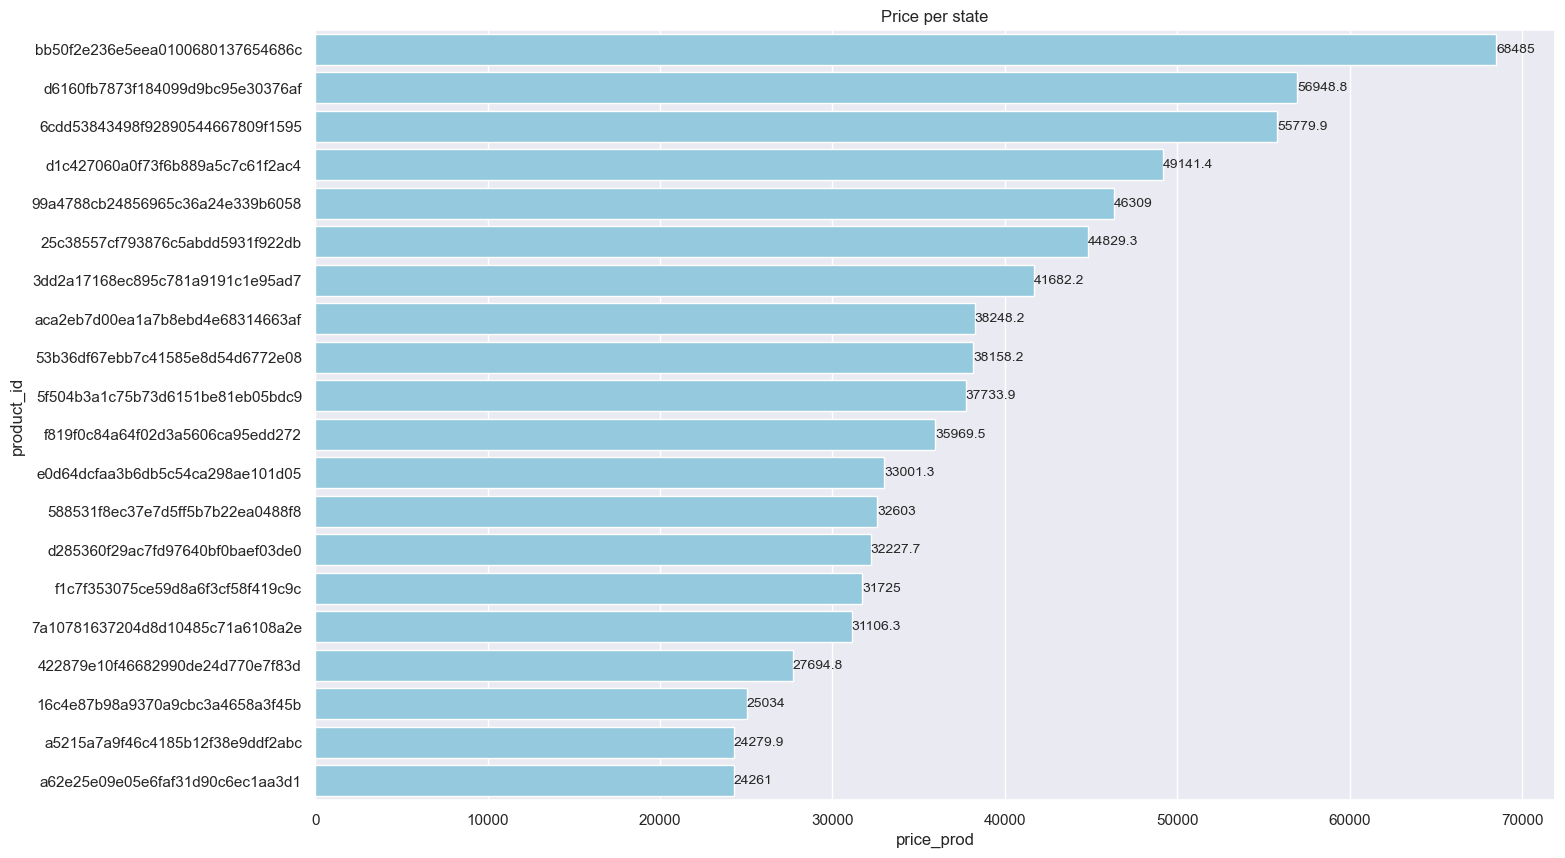

In [168]:
ax = sns.barplot(df_prod_price.head(20), y="product_id", x="price_prod", estimator="sum", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

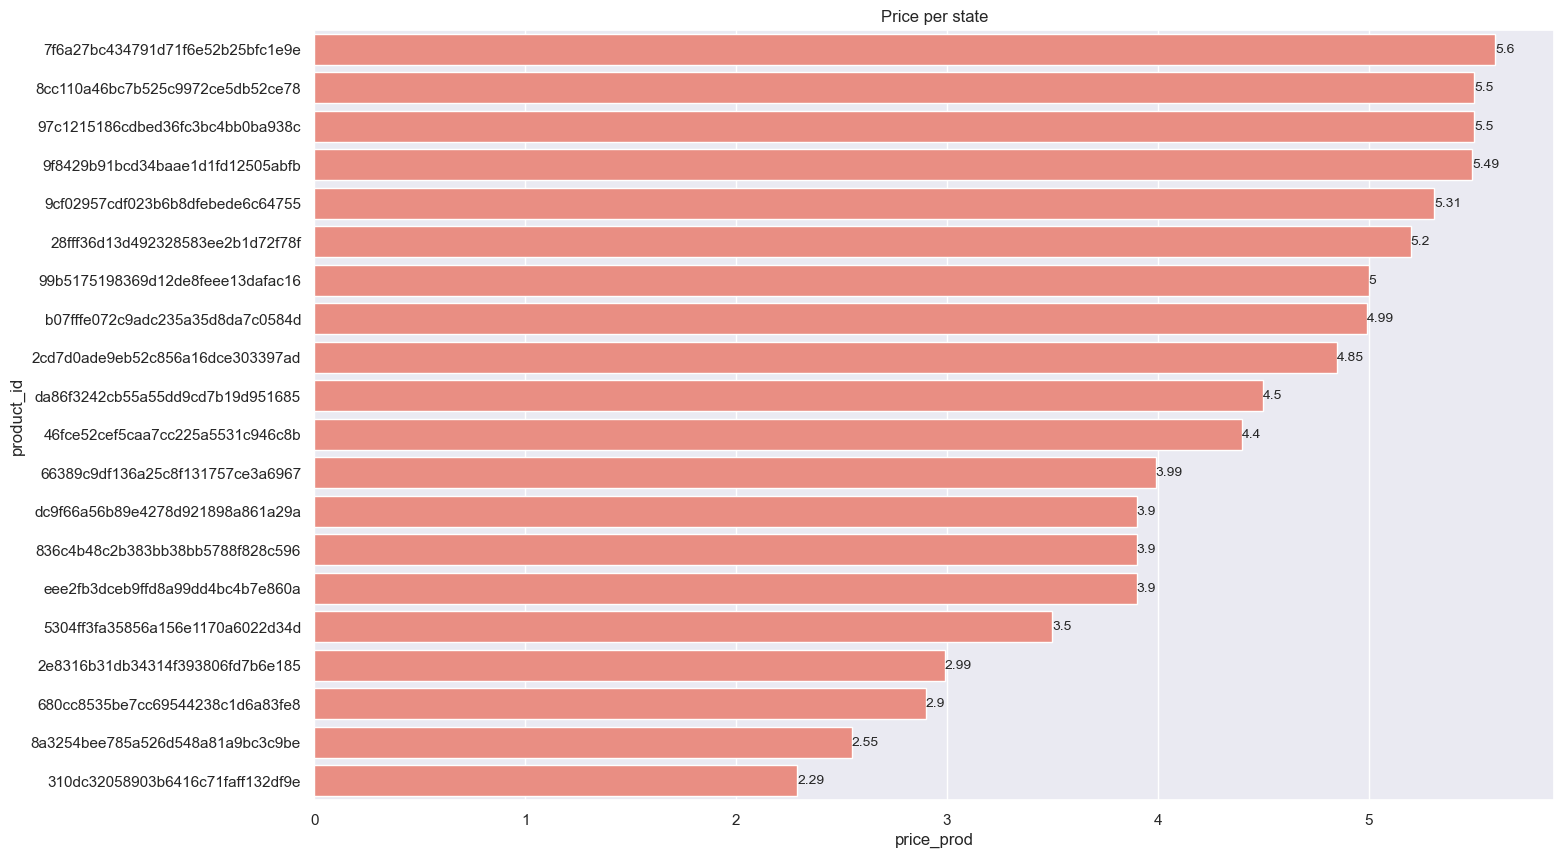

In [170]:
ax = sns.barplot(df_prod_price.tail(20), y="product_id", x="price_prod", estimator="sum", errorbar=None, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

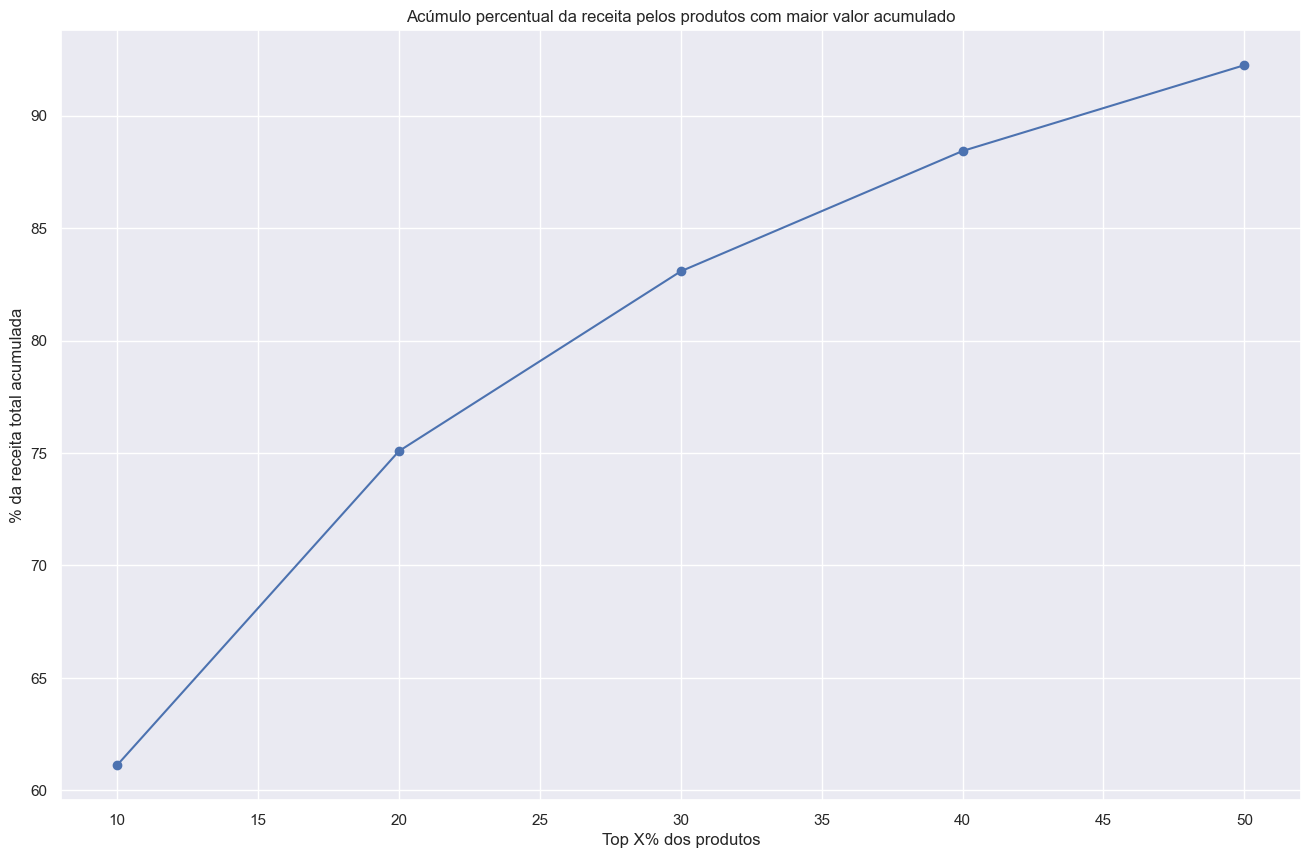

In [178]:
# Transformar isso em funcao. Analisar colocar na axis direita o valor dos preços do minimo ao máximo. noca so do g´rafico, de 60 até 90%
# Função pra fazer especificamente a conta, o grafico não é dificl fazer, mas pensar se faço por causa de ser chato fazer legendas toda hora

df_prod_price['cum_sum'] = df_prod_price['price_prod'].cumsum()
df_prod_price['cum_perc'] = df_prod_price['cum_sum'] / df_prod_price['price_prod'].sum() * 100

percentiles = [10, 20, 30, 40, 50]
index_percentiles = [int(len(df_prod_price) * (p / 100)) for p in percentiles]
perc_values = df_prod_price.iloc[index_percentiles]['cum_perc']

# Plotar
plt.plot(percentiles, perc_values, marker='o')
plt.title('Acúmulo percentual da receita pelos produtos com maior valor acumulado')
plt.xlabel('Top X% dos produtos')
plt.ylabel('% da receita total acumulada')
plt.grid(True)
plt.show()

In [176]:
perc_values

11578    61.115323
11240    75.083283
28482    83.079609
6792     88.431426
6783     92.248544
Name: cum_perc, dtype: float64

In [188]:
df_prod_price

product_id  price_prod  n_prod       cum_sum  \
24086  bb50f2e236e5eea0100680137654686c    68485.00     209  6.848500e+04   
27613  d6160fb7873f184099d9bc95e30376af    56948.83      41  1.254338e+05   
14068  6cdd53843498f92890544667809f1595    55779.90     159  1.812137e+05   
27039  d1c427060a0f73f6b889a5c7c61f2ac4    49141.40     357  2.303551e+05   
19742  99a4788cb24856965c36a24e339b6058    46308.96     525  2.766641e+05   
...                                 ...         ...     ...           ...   
10782  5304ff3fa35856a156e1170a6022d34d        3.50       1  1.420910e+07   
6086   2e8316b31db34314f393806fd7b6e185        2.99       1  1.420911e+07   
13461  680cc8535be7cc69544238c1d6a83fe8        2.90       1  1.420911e+07   
17767  8a3254bee785a526d548a81a9bc3c9be        2.55       3  1.420911e+07   
6388   310dc32058903b6416c71faff132df9e        2.29       1  1.420912e+07   

         cum_perc  
24086    0.481979  
27613    0.882770  
14068    1.275334  
27039    1.621179  
19742    1.947089  
...           ...  
10782   99.999924  
6086    99.999946  
13461   99.999966  
17767   99.999984  
6388   100.000000  

[32951 rows x 5 columns]

In [186]:
(df_prod_price['price_prod'].head(int(0.04*32951)).sum()/df_prod_price['price_prod'].sum())*100

44.12891541775606

In [193]:
df_prod_price = df_prod_price.sort_values(by=['n_prod'], ascending = False)

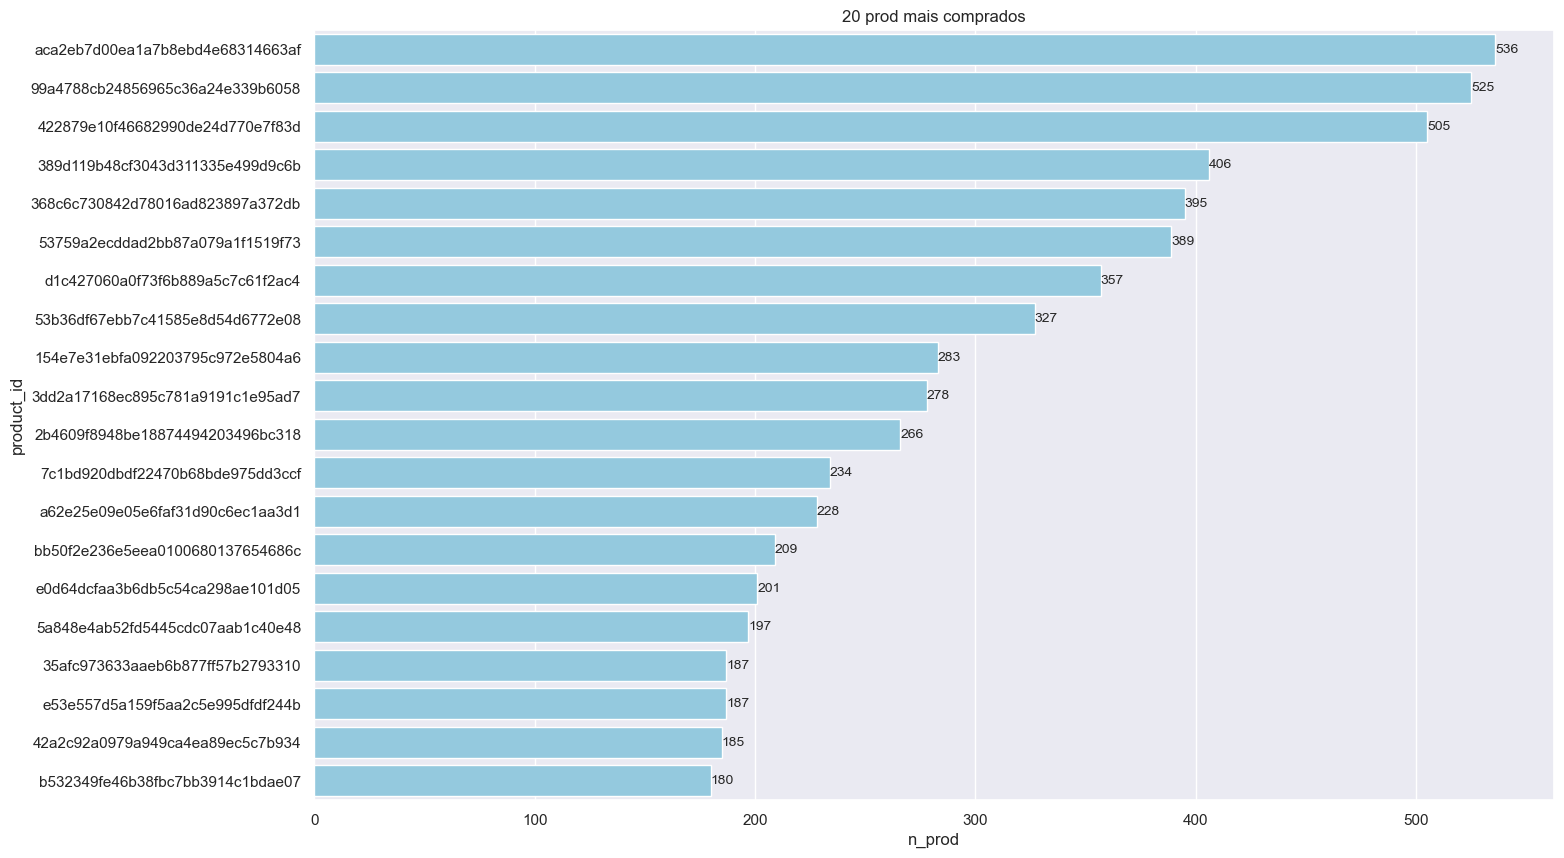

In [195]:
ax = sns.barplot(df_prod_price.head(20), y="product_id", x="n_prod", estimator="sum", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('20 prod mais comprados');

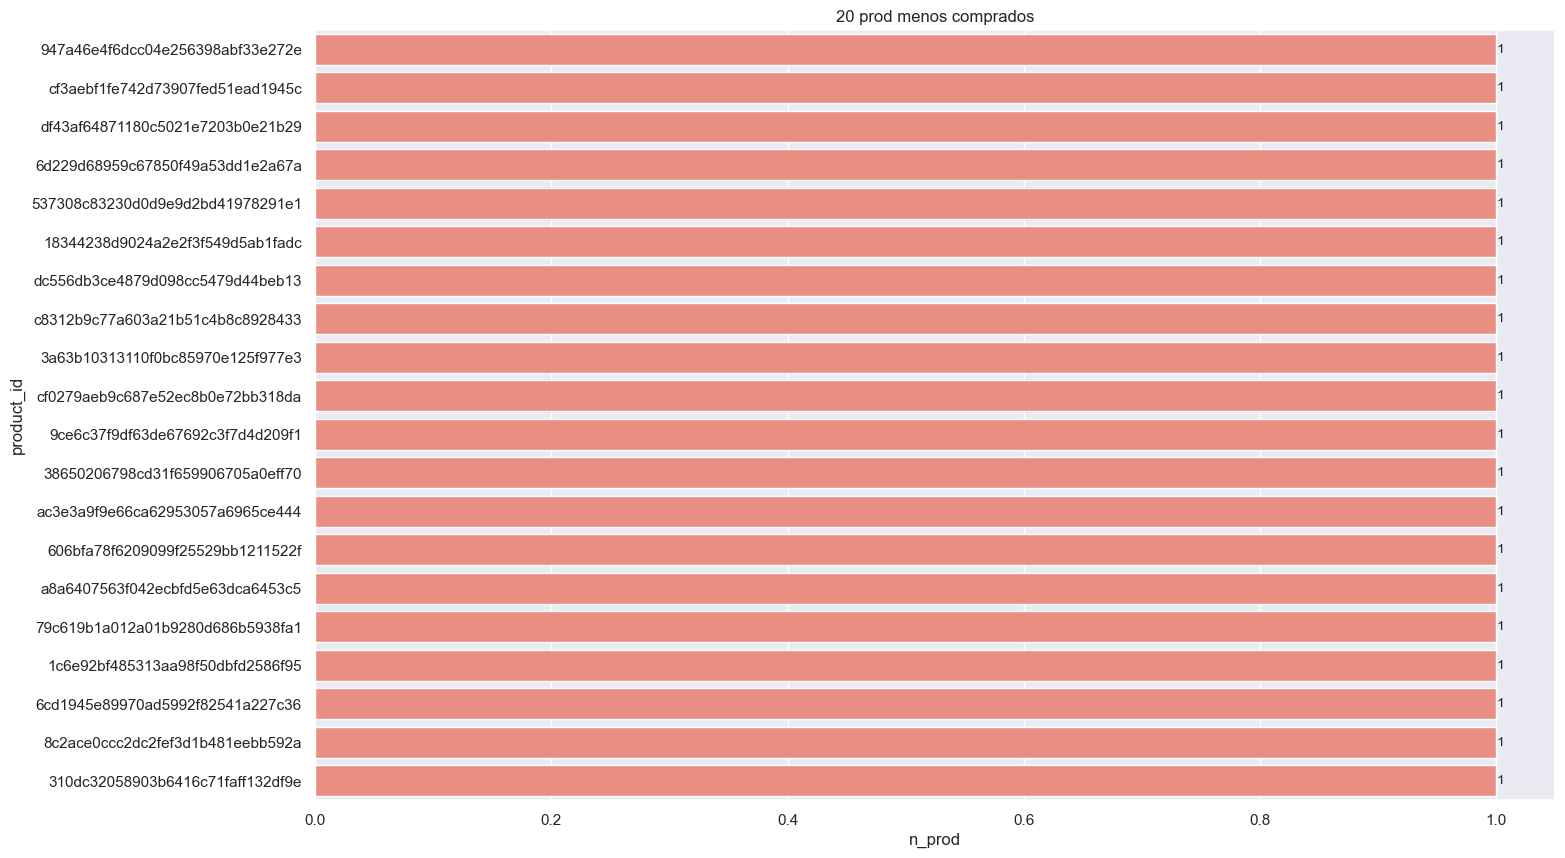

In [197]:
ax = sns.barplot(df_prod_price.tail(20), y="product_id", x="n_prod", estimator="sum", errorbar=None, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('20 prod menos comprados');

#### Ver qts produtos possuem valor de 1, que é o mínimo

## Analise de Produto (ver top 10 mais vendidos e o qt arrecadaram em comparação com o resto. Ver porcentagem já serve.)

### Top 10 mais vendidos (qt venderam cada)

### Top 10 mais que mais foram caros (top 10 dos produtos que mais agregaram valor)

### O quanto equivale o valor em porcentagem neste top 10 em relação a todo resto

In [215]:
df_cat_price = df_eda.groupby(['product_category_name']).agg(price_cat = ('price', 'sum'), n_cat = ('product_category_name', 'count')).reset_index()
df_cat_price = df_cat_price.sort_values(by=['price_cat'], ascending = False)
df_cat_price

product_category_name   price_cat  n_cat
11                   beleza_saude  1297355.80   9972
66             relogios_presentes  1253143.30   6201
13                cama_mesa_banho  1092551.02  11823
32                  esporte_lazer  1023996.34   8945
44         informatica_acessorios   942277.57   8082
..                            ...         ...    ...
41                         flores     1110.04     33
15                casa_conforto_2      773.17     31
17              cds_dvds_musicais      730.00     14
37  fashion_roupa_infanto_juvenil      569.85      8
67             seguros_e_servicos      283.29      2

[73 rows x 3 columns]

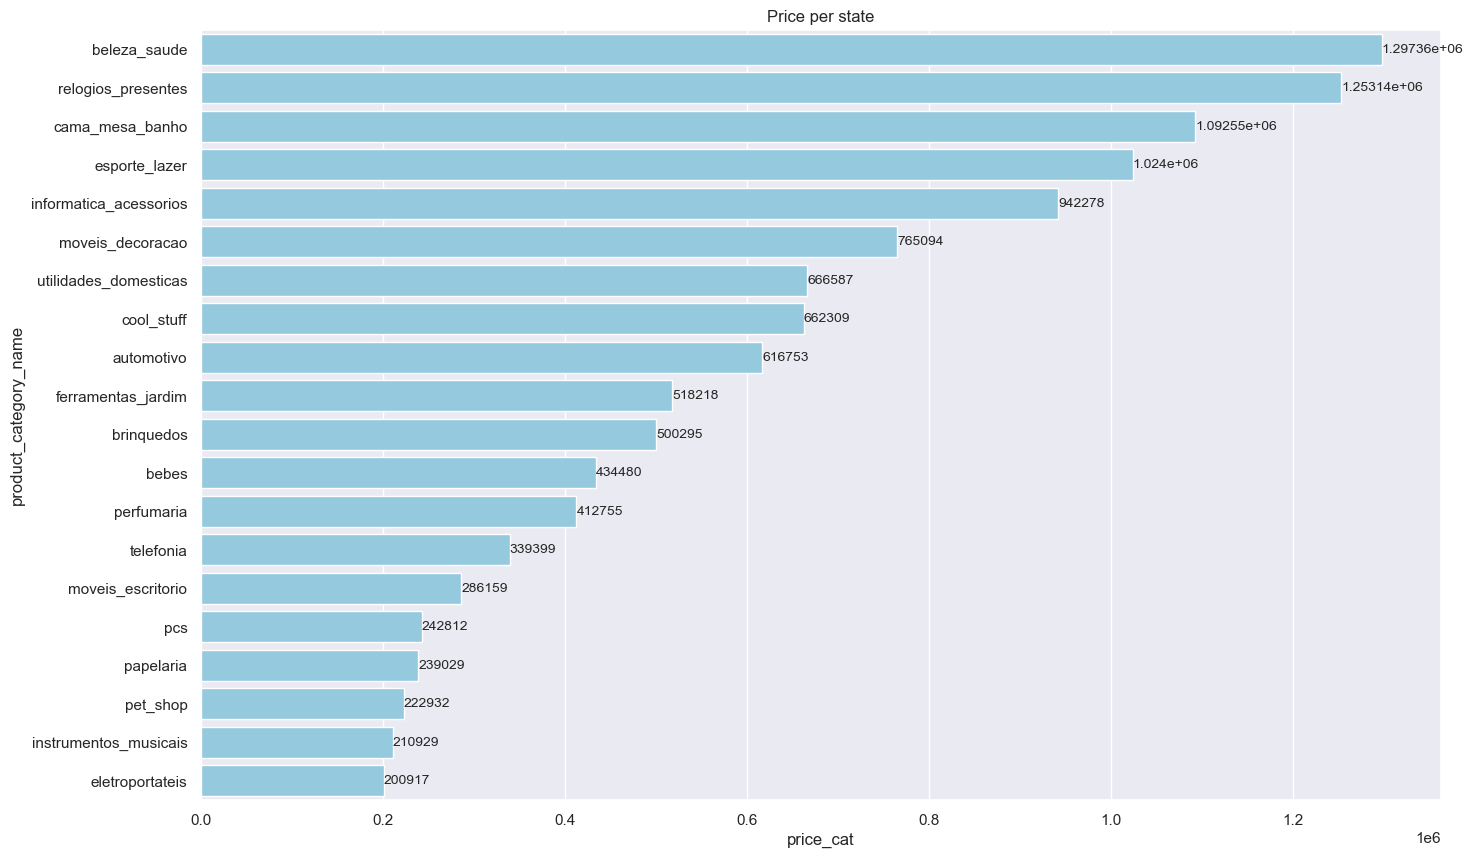

In [223]:
ax = sns.barplot(df_cat_price.head(20), y="product_category_name", x="price_cat", errorbar=None, color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

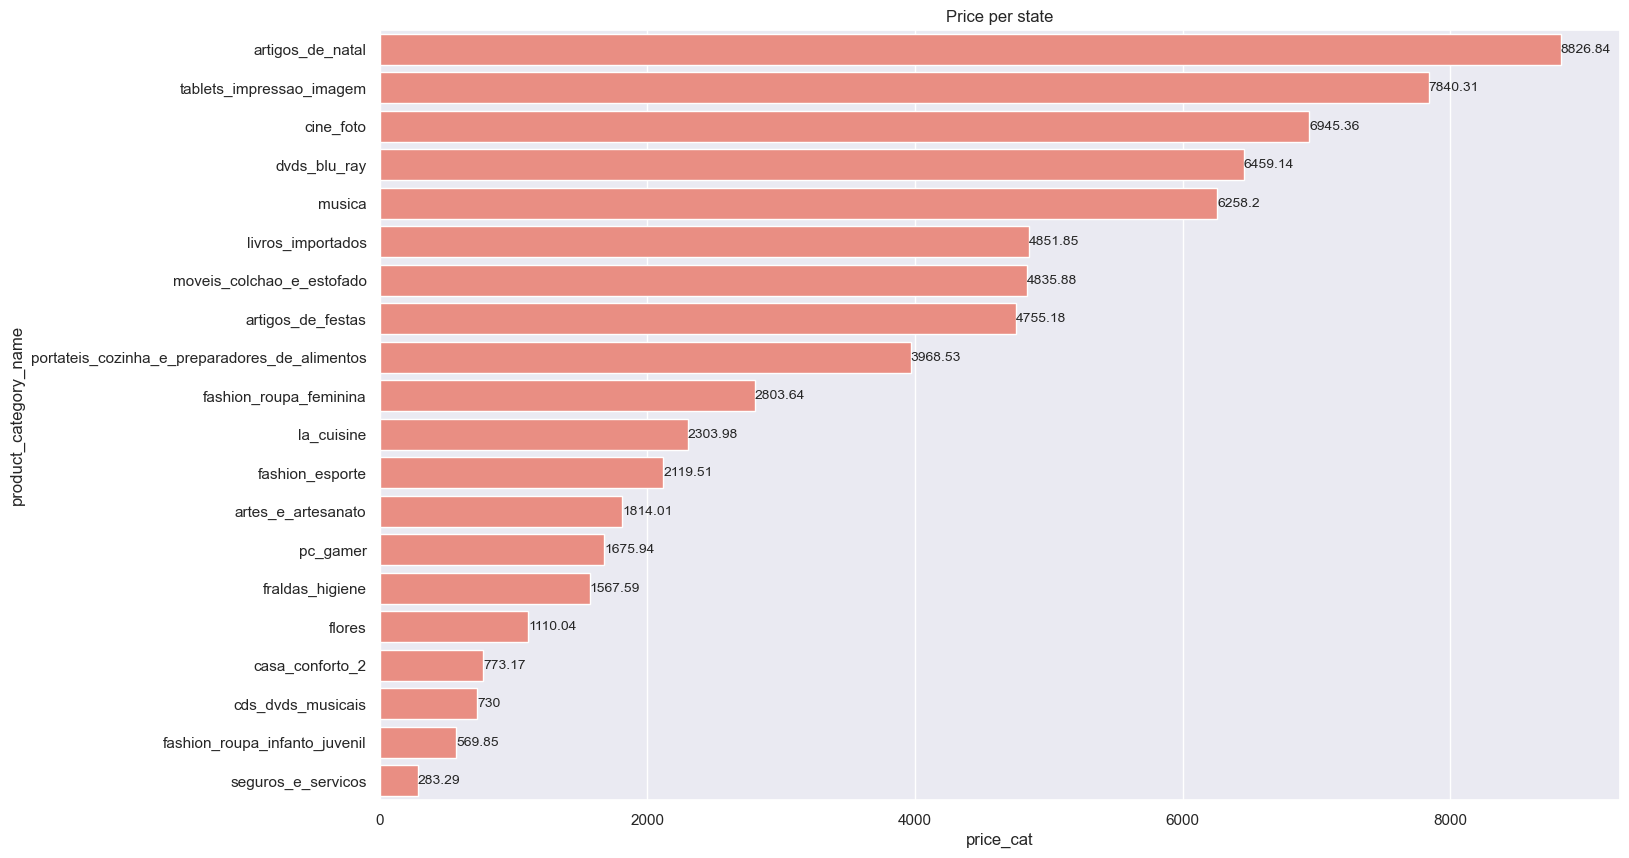

In [225]:
ax = sns.barplot(df_cat_price.tail(20), y="product_category_name", x="price_cat", errorbar=None, color='salmon')
ax.bar_label(ax.containers[0], fontsize=10); # Colocar o ; impede que haja a legenda embaixo. Fantástico
ax.set_title('Price per state');

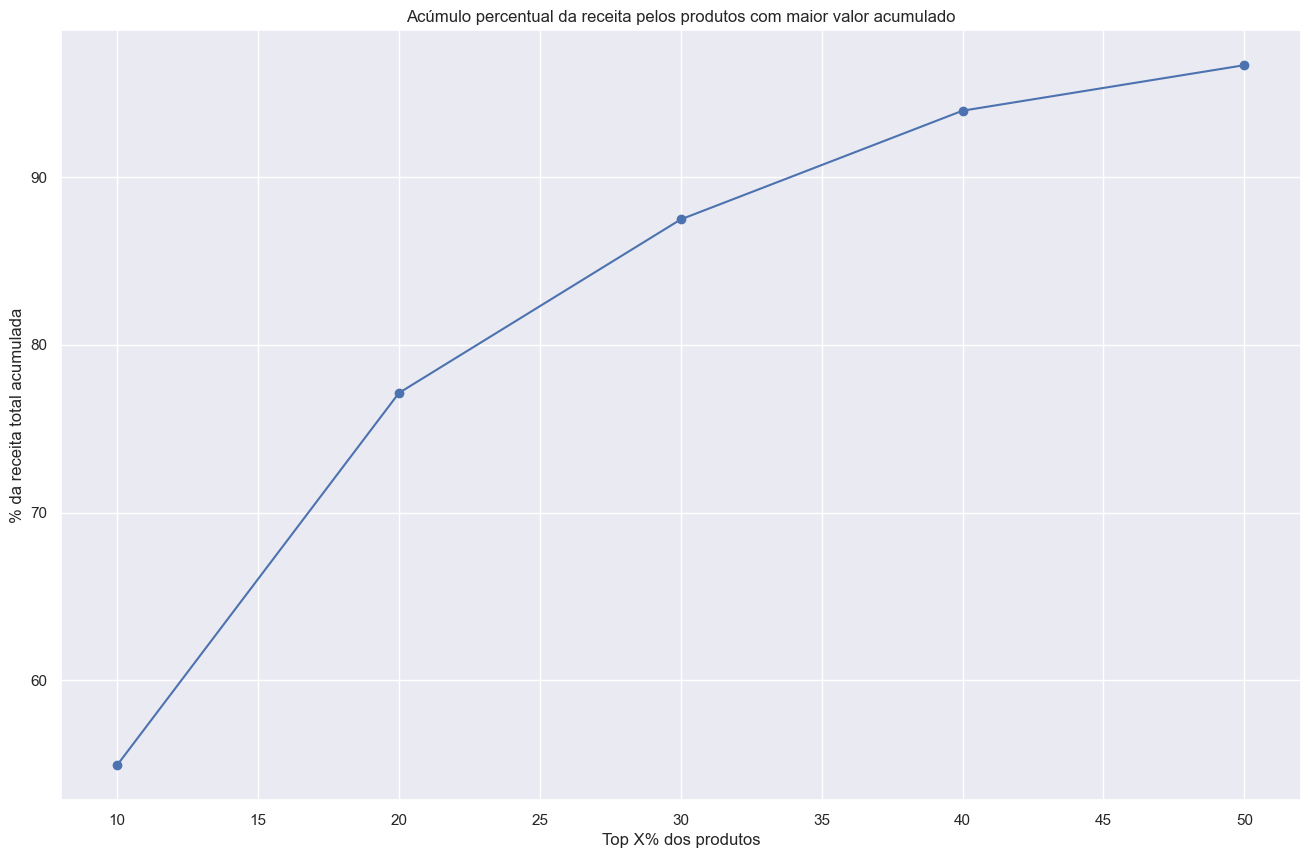

In [233]:
# Transformar isso em funcao. Analisar colocar na axis direita o valor dos preços do minimo ao máximo. noca so do g´rafico, de 60 até 90%
# Função pra fazer especificamente a conta, o grafico não é dificl fazer, mas pensar se faço por causa de ser chato fazer legendas toda hora

df_cat_price['cum_sum'] = df_cat_price['price_cat'].cumsum()
df_cat_price['cum_perc'] = df_cat_price['cum_sum'] / df_cat_price['price_cat'].sum() * 100

percentiles = [10, 20, 30, 40, 50]
index_percentiles = [int(len(df_cat_price) * (p / 100)) for p in percentiles]
perc_values = df_cat_price.iloc[index_percentiles]['cum_perc']

# Plotar
plt.plot(percentiles, perc_values, marker='o')
plt.title('Acúmulo percentual da receita pelos produtos com maior valor acumulado')
plt.xlabel('Top X% dos produtos')
plt.ylabel('% da receita total acumulada')
plt.grid(True)
plt.show()

In [237]:
df_cat_price

product_category_name   price_cat  n_cat      cum_sum    cum_perc
11                   beleza_saude  1297355.80   9972   1297355.80    9.254823
66             relogios_presentes  1253143.30   6201   2550499.10   18.194252
13                cama_mesa_banho  1092551.02  11823   3643050.12   25.988079
32                  esporte_lazer  1023996.34   8945   4667046.46   33.292864
44         informatica_acessorios   942277.57   8082   5609324.03   40.014699
..                            ...         ...    ...          ...         ...
41                         flores     1110.04     33  14015802.44   99.983191
15                casa_conforto_2      773.17     31  14016575.61   99.988707
17              cds_dvds_musicais      730.00     14  14017305.61   99.993914
37  fashion_roupa_infanto_juvenil      569.85      8  14017875.46   99.997979
67             seguros_e_servicos      283.29      2  14018158.75  100.000000

[73 rows x 5 columns]

In [243]:
(df_cat_price['price_cat'].head(int(0.50*len(df_cat_price))).sum()/df_cat_price['price_cat'].sum())*100

96.3083810846414

In [84]:
df_eda.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'product_category_name',
 'month_order',
 'year_order']

In [101]:
df_eda['order_delivered_carrier_date'][0] - df_eda['order_purchase_timestamp'][0]

Timedelta('6 days 19:42:22')

## Month Influence

### Gasto em meses  (necessita organizar ordem dos meses) (Utilizar month_order_n)

In [94]:
df_test = df_eda.groupby(['year_order', 'month_order']).agg(total_price = ('price', 'sum'), avg_price = ('price', 'mean'))
df_test

total_price   avg_price
year_order month_order                         
2016       December           10.90   10.900000
           October         50942.23  133.706640
           September         132.39   44.130000
2017       April          391784.42  137.227468
           August         601409.67  116.326822
           December       770656.15  117.406482
           February       260753.86  126.456770
           January        128637.99  127.998000
           July           533616.84  110.251413
           June           453031.41  119.817882
           March          396451.04  124.630946
           May            545340.65  124.053833
           November      1046127.84  116.030151
           October        693807.60  124.561508
           September      662276.39  129.883583
2018       April         1029472.30  124.618363
           August         884657.40  118.554999
           February       880099.79  111.095656
           January        987151.41  115.523863
           July           925302.46  126.217768
           June           909221.10  123.033978
           March         1025936.06  120.076786
           May           1032150.44  125.550473
           September         145.00  145.000000

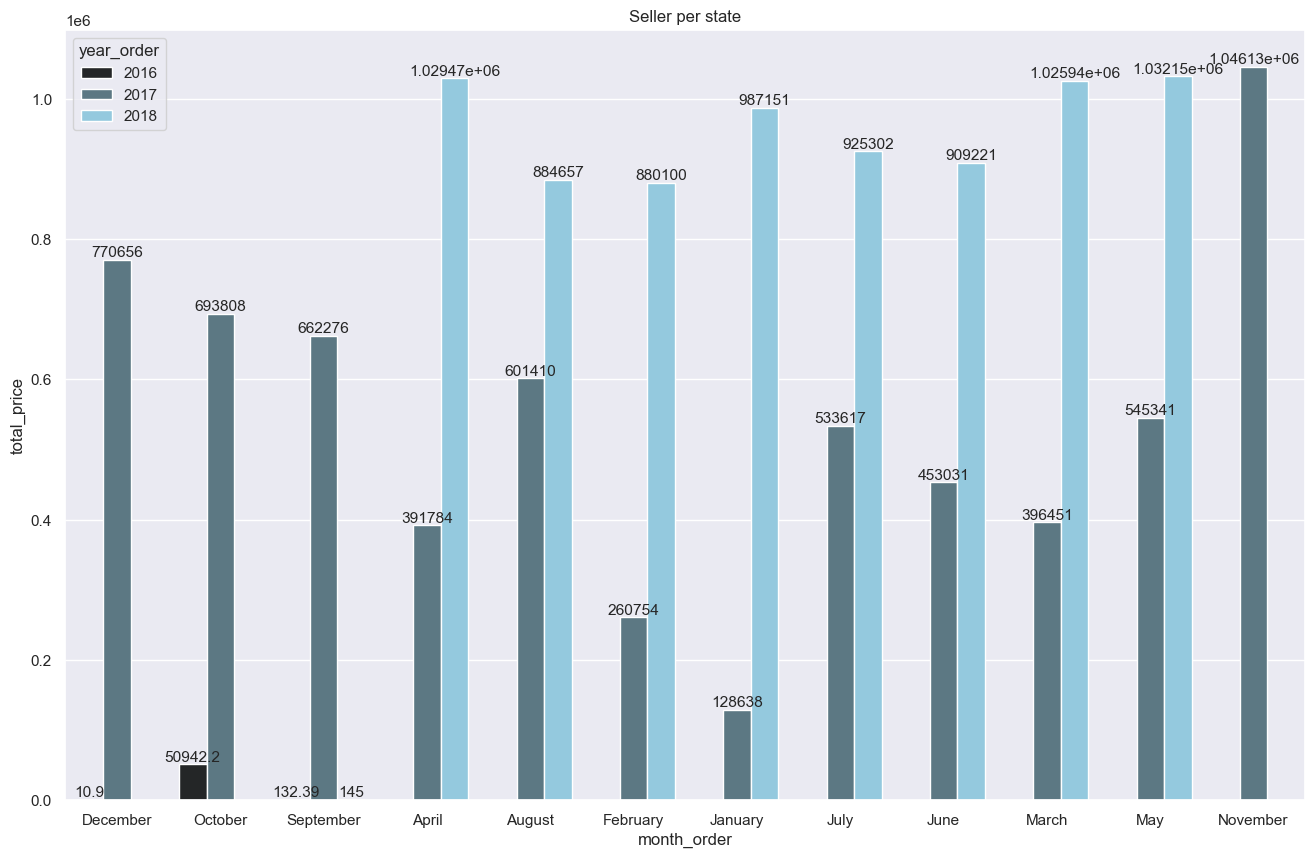

In [129]:
ax = sns.barplot(data = df_test, y='total_price', x="month_order", hue = 'year_order', errorbar=None, palette='dark:skyblue')
ax.bar_label(ax.containers[0], fontsize=11.2);
ax.bar_label(ax.containers[1], fontsize=11.2);
ax.bar_label(ax.containers[2], fontsize=11.2);
#ax.tick_params(axis='x', rotation=90)
ax.set_title('Seller per state');

### numero de venda em meses

In [153]:
df_test2 = df_eda.groupby(['year_order', 'month_order']).agg(n_orders = ('customer_id', 'count'))
df_test2

n_orders
year_order month_order          
2016       December            1
           October           381
           September           3
2017       April            2855
           August           5170
           December         6564
           February         2062
           January          1005
           July             4840
           June             3781
           March            3181
           May              4396
           November         9016
           October          5570
           September        5099
2018       April            8261
           August           7462
           February         7922
           January          8545
           July             7331
           June             7390
           March            8544
           May              8221
           September           1

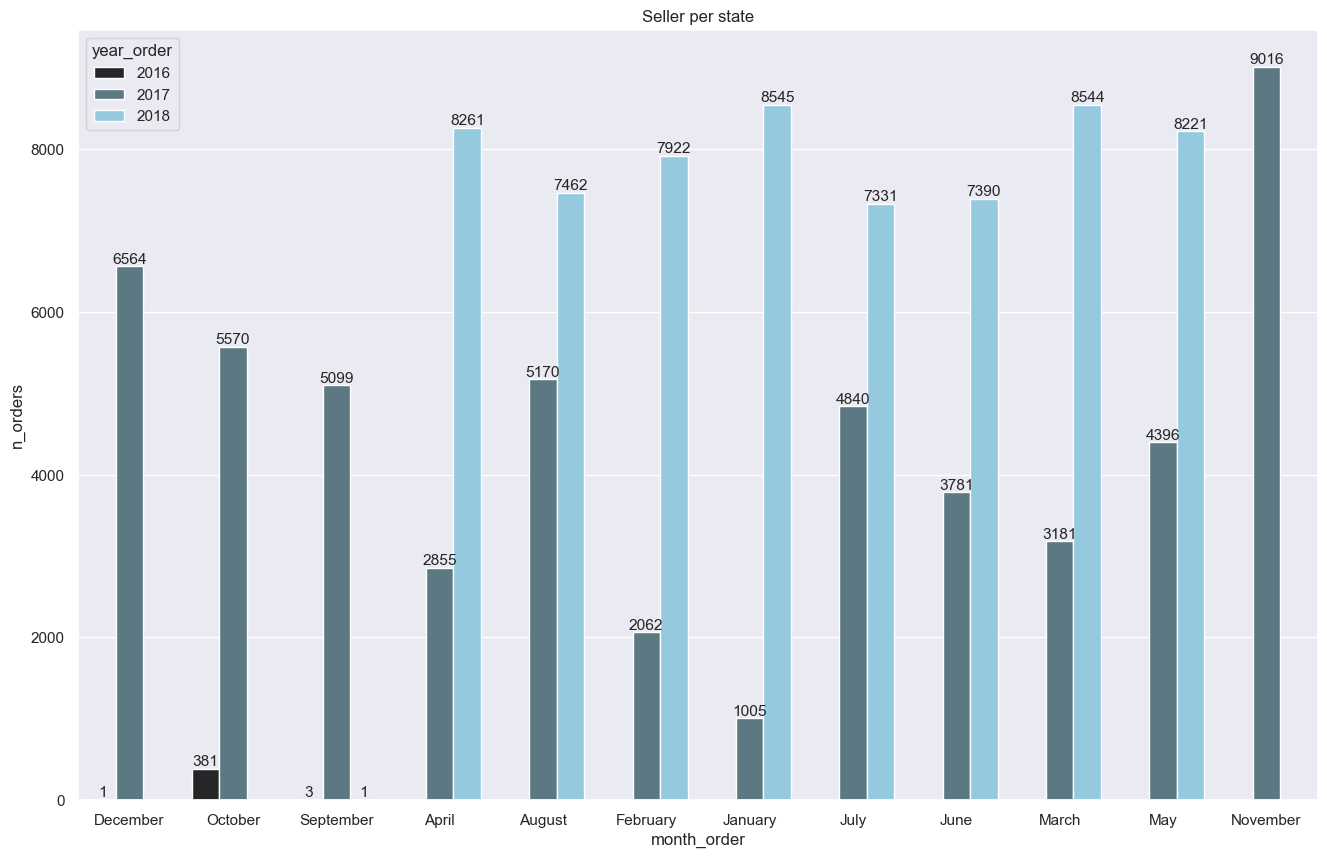

In [157]:
ax = sns.barplot(data = df_test2, y='n_orders', x="month_order", hue = 'year_order', errorbar=None, palette='dark:skyblue')
ax.bar_label(ax.containers[0], fontsize=11.2);
ax.bar_label(ax.containers[1], fontsize=11.2);
ax.bar_label(ax.containers[2], fontsize=11.2);
#ax.tick_params(axis='x', rotation=90)
ax.set_title('Seller per state');

## Produtos mais vendidos (barplot) -> Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight) (contar ids)

## Produtos mais caros (barplot) -> Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight)

In [118]:
df_delivered.shape

(115035, 28)

## Analise tempo ordem (diferença entre tempo de compra e os outros tempos)

Ok, temos vários outliers. 

Vou tratar isso ndiidualmente com base no describe

https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

https://stackoverflow.com/questions/57593005/how-to-replace-the-outliers-with-the-95th-and-5th-percentile-in-python

In [55]:
df_order_time = pd.DataFrame()
df_order_time['purchased_approved'] = df_delivered['order_approved_at'] - df_delivered['order_purchase_timestamp'] # diferença entre comprovação do pagamento e aceitamento da compra
df_order_time['purchased_carrier'] = df_delivered['order_delivered_carrier_date'] - df_delivered['order_purchase_timestamp'] # diferença de tepmo entre  pagamento e ordem entrega ao transporte logistico
df_order_time['purchased_customer'] = df_delivered['order_delivered_customer_date'] - df_delivered['order_purchase_timestamp'] # diferença de tempo entre pagamento e entrega ao cliente

df_order_time['estimated_delivered'] = df_delivered['order_delivered_customer_date'] - df_delivered['order_estimated_delivery_date'] # diferença de entrega atual e estimada
df_order_time['estimated_shipping'] = df_delivered['order_delivered_carrier_date'] - df_delivered['shipping_limit_date'] # Diferença entre tempo de entrega ao transportador real e estiamdo

#df_order_time

In [57]:
df_order_time.describe()

purchased_approved          purchased_carrier  \
count                     115011                     115011   
mean   0 days 10:25:52.716905339  3 days 06:46:27.134239333   
std    0 days 20:56:20.477384153  3 days 15:30:44.617405560   
min              0 days 00:00:00        -172 days +18:54:07   
25%              0 days 00:12:57     1 days 03:17:32.500000   
50%              0 days 00:20:48            2 days 05:29:02   
75%              0 days 14:55:10            4 days 02:46:12   
max             30 days 21:26:37          125 days 18:36:45   

               purchased_customer           estimated_delivered  \
count                      115011                        115011   
mean   12 days 11:35:25.914982045  -12 days +15:44:09.094156212   
std     9 days 10:51:44.878696848    10 days 03:53:45.095109380   
min               0 days 12:48:07           -147 days +23:36:47   
25%        6 days 17:56:33.500000     -17 days +16:27:42.500000   
50%              10 days 04:42:27            -13 days +22:40:08   
75%              15 days 12:58:46      -7 days +11:59:59.500000   
max             209 days 15:05:12             188 days 23:24:07   

                estimated_shipping  
count                       115011  
mean   -4 days +16:17:29.870777578  
std      5 days 17:59:25.815322249  
min           -1047 days +03:28:20  
25%       -6 days +19:13:20.500000  
50%              -4 days +18:48:00  
75%       -2 days +11:07:03.500000  
max              116 days 18:18:06

Observamos uma grande quantidade de outliers. Removeremos então os maiores e menores 5% (o valor que sobrará será entre 5% < x < 95%):

Não dá certo. Preciso fazer isso pra cada uma das amostras, tá muito ruim em algumas partes;

In [97]:
#df_order_time['purchased_approved'] = df_order_time['purchased_approved'].dt.total_seconds()

In [53]:
#df_order_time = df_order_time.clip(lower=df_order_time.quantile(0.03), upper=df_order_time.quantile(0.97), axis = 1)
#df_order_time.describe()

In [61]:
df_order_time['purchased_approved'] = df_order_time['purchased_approved'].clip(upper=df_order_time['purchased_approved'].quantile(0.97))

df_order_time['purchased_carrier'] = df_order_time['purchased_carrier'].clip(lower=df_order_time['purchased_carrier'].quantile(0.03), 
                                                                              upper=df_order_time['purchased_carrier'].quantile(0.97))

df_order_time['purchased_customer'] = df_order_time['purchased_customer'].clip(upper=df_order_time['purchased_customer'].quantile(0.97))

df_order_time['estimated_delivered'] = df_order_time['estimated_delivered'].clip(lower=df_order_time['estimated_delivered'].quantile(0.03), 
                                                                                upper=df_order_time['estimated_delivered'].quantile(0.97))

df_order_time['estimated_shipping'] = df_order_time['estimated_shipping'].clip(lower=df_order_time['estimated_shipping'].quantile(0.03), 
                                                                               upper=df_order_time['estimated_shipping'].quantile(0.97))

In [63]:
df_order_time.describe()

purchased_approved           purchased_carrier  \
count                     115011                      115011   
mean   0 days 09:36:54.057613619   3 days 02:27:44.547301562   
std    0 days 16:41:36.471221053   2 days 15:21:44.419669732   
min              0 days 00:00:00   0 days 07:09:42.599999999   
25%              0 days 00:12:57      1 days 03:17:32.500000   
50%              0 days 00:20:48             2 days 05:29:02   
75%              0 days 14:55:10             4 days 02:46:12   
max    2 days 16:29:11.199999999  11 days 17:10:00.099999999   

               purchased_customer           estimated_delivered  \
count                      115011                        115011   
mean   12 days 02:38:31.850826442  -12 days +12:16:51.814328195   
std     7 days 14:58:45.882826918     8 days 01:31:02.923419501   
min               0 days 12:48:07            -29 days +08:43:34   
25%        6 days 17:56:33.500000     -17 days +16:27:42.500000   
50%              10 days 04:42:27            -13 days +22:40:08   
75%              15 days 12:58:46      -7 days +11:59:59.500000   
max    34 days 07:12:32.399999999        7 days 19:57:38.700000   

                estimated_shipping  
count                       115011  
mean   -4 days +15:30:28.913522185  
std      2 days 13:41:20.267259949  
min      -10 days +19:59:45.700000  
25%       -6 days +19:13:20.500000  
50%              -4 days +18:48:00  
75%       -2 days +11:07:03.500000  
max      2 days 07:45:11.399999999

In [115]:
df_order_time = df_order_time.apply(lambda x: x.dt.days)
df_order_time.describe()

purchased_approved  purchased_carrier  purchased_customer  \
count       115011.000000      115011.000000       115011.000000   
mean             0.230161           2.602421           11.649268   
std              0.531115           2.642848            7.645021   
min              0.000000           0.000000            0.000000   
25%              0.000000           1.000000            6.000000   
50%              0.000000           2.000000           10.000000   
75%              0.000000           4.000000           15.000000   
max              2.000000          11.000000           34.000000   

       estimated_delivered  estimated_shipping  
count        115011.000000       115011.000000  
mean            -12.180296           -3.860092  
std               8.031991            2.619358  
min             -29.000000          -10.000000  
25%             -17.000000           -6.000000  
50%             -13.000000           -4.000000  
75%              -7.000000           -2.000000  
max               7.000000            2.000000

<Axes: xlabel='purchased_approved'>

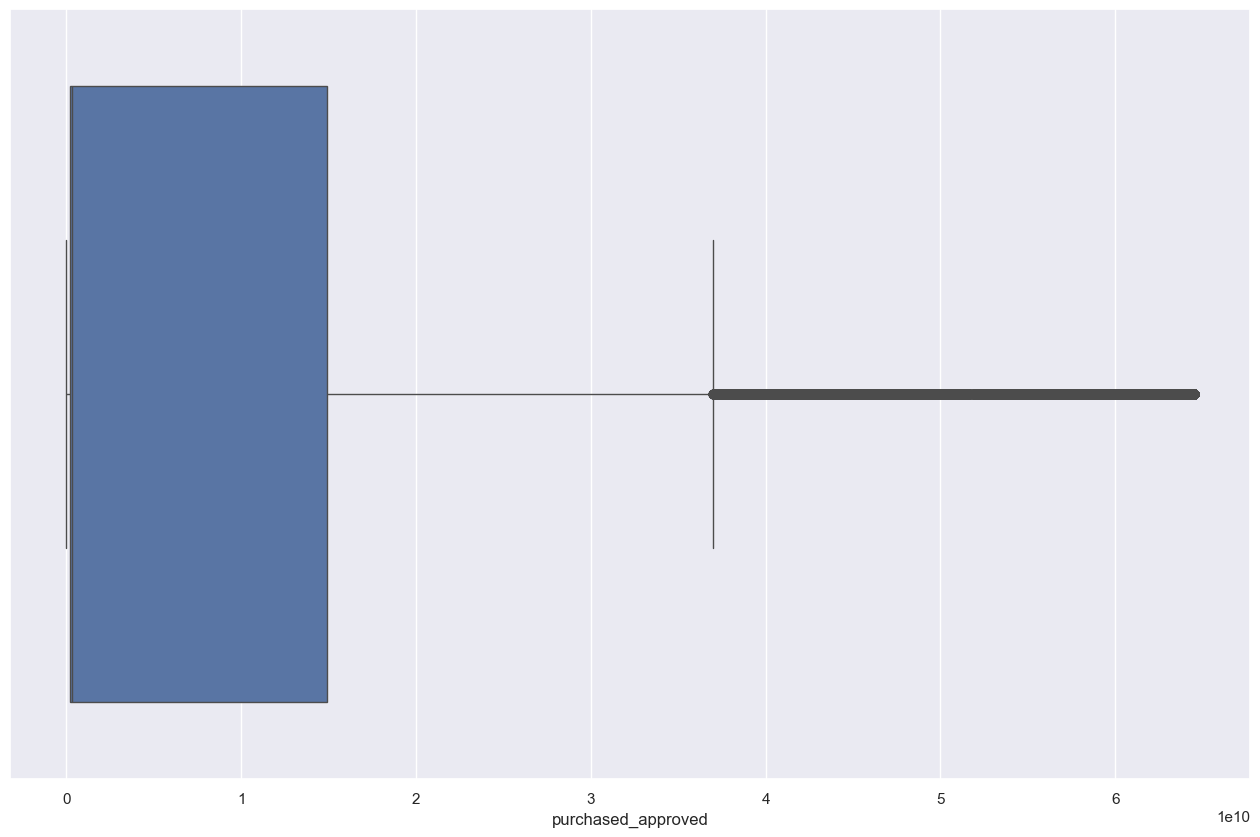

In [65]:
sns.boxplot(x=df_order_time['purchased_approved']/3600)

In [ ]:
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=df_order_time)

In [89]:
df_order_time

purchased_approved          purchased_carrier purchased_customer  \
0         0 days 00:16:37            6 days 19:42:22    8 days 19:30:00   
1         0 days 00:10:08            2 days 20:26:35   16 days 15:52:55   
2         1 days 00:11:25 11 days 17:10:00.099999999   26 days 01:51:06   
3         0 days 01:22:41 11 days 17:10:00.099999999   14 days 23:57:47   
4         0 days 00:18:39            1 days 05:24:30   11 days 11:04:18   
...                   ...                        ...                ...   
117596    0 days 00:20:28            3 days 10:20:19    6 days 04:18:20   
117597    0 days 00:14:50            1 days 10:22:13    7 days 10:34:23   
117598    0 days 00:18:13            0 days 21:40:27   30 days 22:51:25   
117599    0 days 00:22:47            2 days 21:16:08   12 days 22:50:06   
117600    0 days 04:23:16            2 days 04:49:58    7 days 04:15:13   

       estimated_delivered        estimated_shipping  
0       -11 days +10:35:35           0 days 19:25:45  
1        -8 days +12:41:19         -4 days +20:16:27  
2          1 days 17:58:51 2 days 07:45:11.399999999  
3       -13 days +16:04:25           0 days 06:51:26  
4        -6 days +20:55:48         -1 days +05:05:51  
...                    ...                       ...  
117596  -12 days +20:06:37         -2 days +09:59:51  
117597   -9 days +18:54:45         -5 days +10:07:23  
117598     7 days 19:03:15         -4 days +21:22:14  
117599  -19 days +19:58:39         -4 days +21:08:50  
117600  -13 days +18:42:36         -5 days +00:26:42  

[115011 rows x 5 columns]

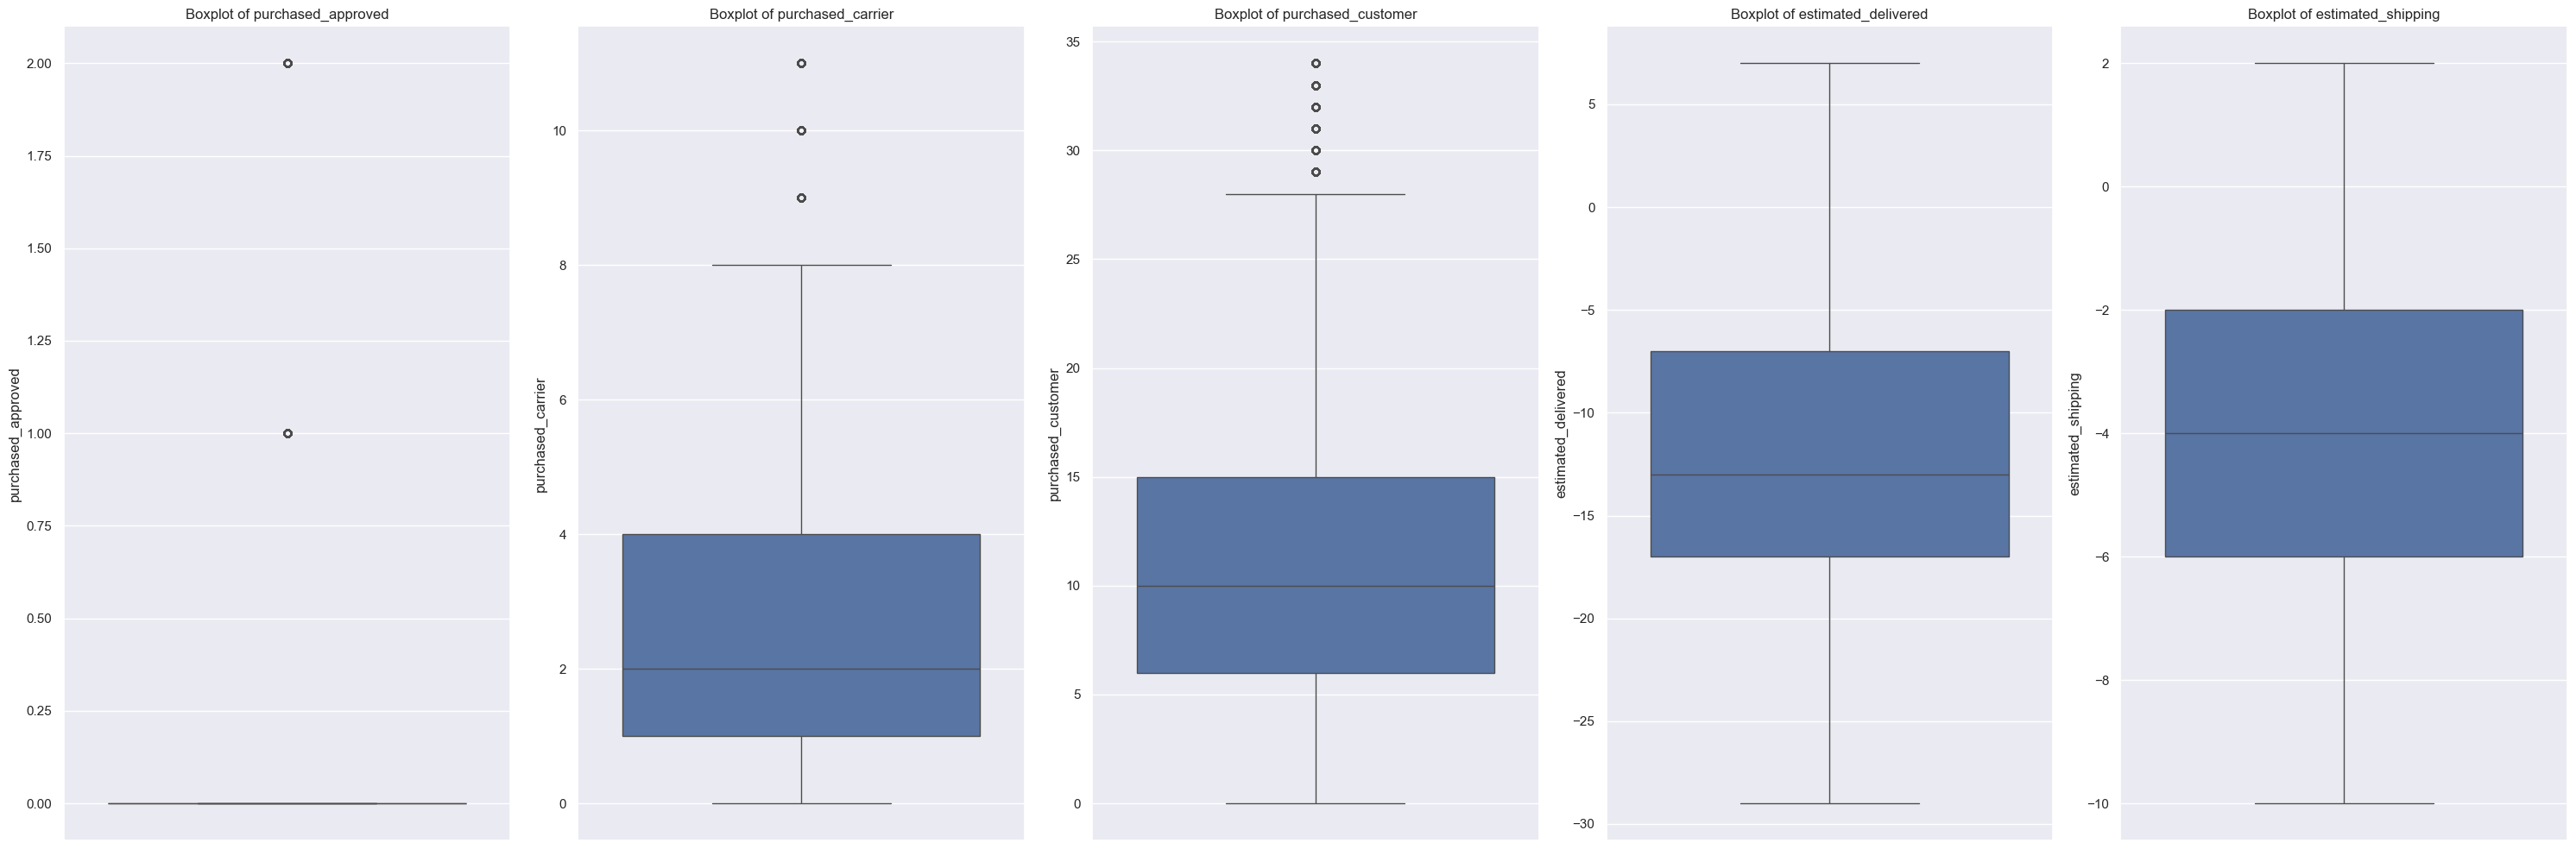

In [117]:
def plot_boxplots(df):
    """Generates boxplots for all columns in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
    """
    num_cols = len(df.columns)
    fig, axes = plt.subplots(1, num_cols, figsize=(6 * num_cols, 10))

    for i, column in enumerate(df.columns):
      sns.boxplot(y=df[column], ax=axes[i])
      axes[i].set_title(f'Boxplot of {column}')

    plt.tight_layout()
    plt.show()
    return (None)

plot_boxplots(df_order_time)

<Axes: xlabel='variable', ylabel='value'>

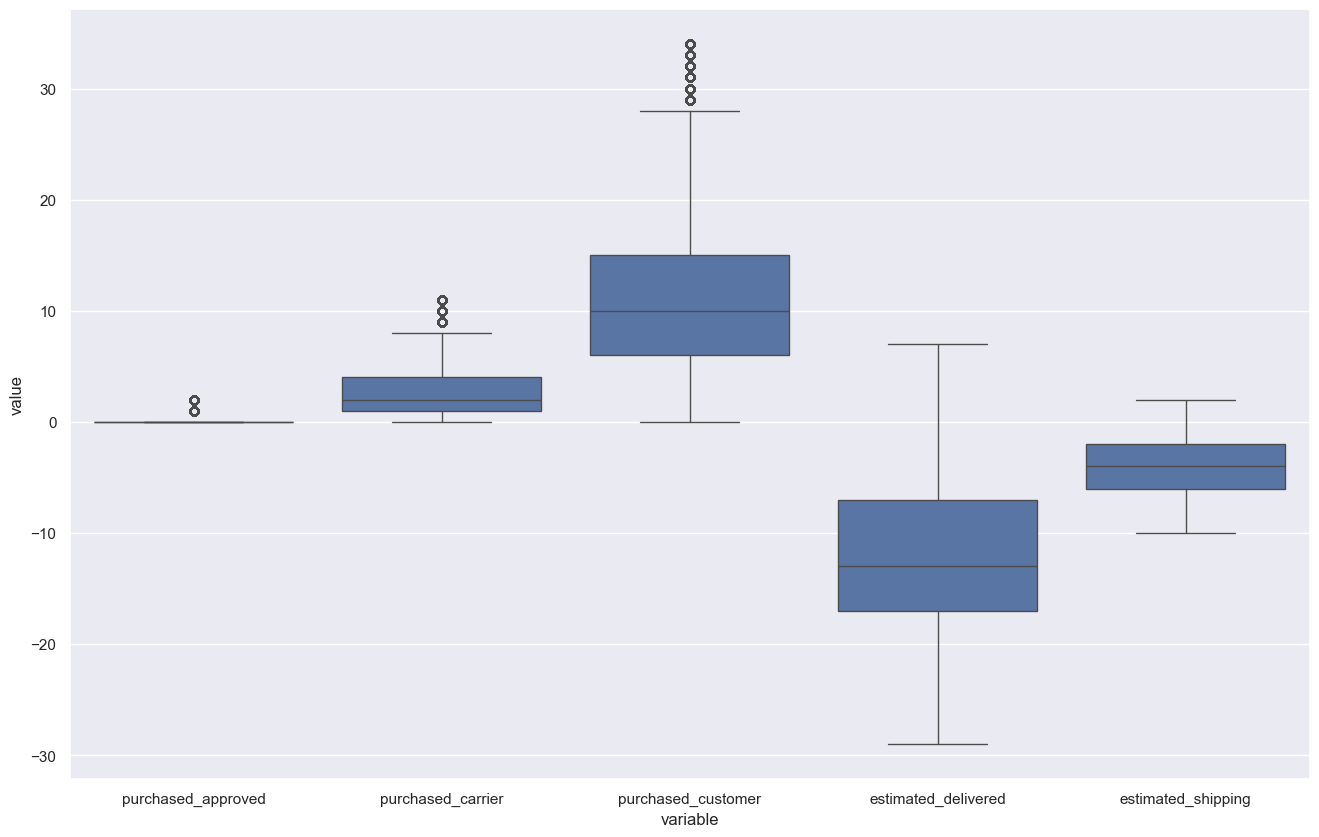

In [119]:
df_melted = pd.melt(df_order_time)

sns.boxplot(x='variable', y='value', data=df_melted)

Fazer função para plotar igual ao que foi plotado acima tendo variávies para:

selecionar colunas que serão utlizadas (em um if)
selecionar se será em minutos, segundos, dias, anos, etc
selecionar dataframe


provavelmente vou dividir nos seguinds grupos: 
 - purchased_approved
 - purchased_carrier + purchased_customer
 - estimated_delivered + estimated_shipped

### Price x Time Top 10 Products

### Price x Time Top 10 Categories

## Análises mais básicas e brutas:
- ✔ estados que mais compraram (Count em df_customers) -> Fazer estados com histograma e linha para valor em reais gasto  
- ✔ estados que mais venderam (Count em df_sellers) -> Fazer estados com histograma e linha para valor em reais gasto      
    - Deixar cores pra estados de cada região (ex: azul sul, vermelho norte, verde centroeste, etc. Da pra fazer com um HUE sem legenda)
- ✔ Produtos mais vendidos (barplot) ->  Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight) (contar ids)
- ✔ Produtos mais caros (barplot) ->  Fazer barra de outra cor para mostrar junto o quanto foi gasto em frete (price and freight)
- ✔ Estados com mais vendedores (Contar ID de vendedores)
- ✔ Estados com mais clientes (Contar ID de clientes)
- ✔ Diferenças de tempos de: (Ver siso pra todos os status) -> Ver através de tempo médio de (e fazer isso pra os 4 tempos) (talvez mudar isso pra analisede tempo)
    - ✔ Fazer diferenaçs de: pedido aprovacao, pedido entrega, pedido recebimento.
    - ✔ Pedido
    - ✔ Aprovação
    - ✔ Entrega
    - ✔ Recebimento
- ✔ Meses com mais consumo -> Fazer estados com histograma e linha para valor em reais gasto (nesse caso, soma cumulativa?) (barplot + hue ano)
- ✔ Meses com mais vendas -> Fazer estados com histograma e linha para valor em reais gasto (nesse caso, soma cumulativa?) (barplot + hue ano)
- Observar relação produto x mes (influencia de tipo de produto como para feriados especificos como dia das mães, pais, criança, namorados, etc)
    - barchart ou histograma dos 10 produtos mais vendidos e preço deles em cada mes
    - Grafico pizza por mes e produto mais comprado. Tentar ignorar vlores menores que 2% (Deixa isso pro BI)
- Número de fotos do produto influencia
- ✔ Forma de pagamento (piechart)
- ✔ Status (piechart)
- ✔ df_orders adicionar estados do vendedor e cliente para analisar diferença de tempo
- Forma de pagamento x dinheiro (boxplot)
- Forma de pagamento x status (boxplot)
- Status x dinheiro
- ✔ Quanto % das vendas representam o:
    - ✔ 10 Tipo de produto mais vendido -> ver qt dinheiro isso representa
    - ✔ 10 Melhores vendedores -> ver qt dinheiro isso representa
- ✔ Ver quanto % das vendas totais equivalem os 10 produtos que mais venderam (analise estilo pareto)
- Na parte da análise temporal: plto dos 10 produtos mais venidos e suas vendas com o tempo (soma cumulativa)

* Fazer funções para:
    * Histogramas
    * PieChart


- Testar trocar histogramas por barplot por causa da ordem. 
    - data = opening_loc['City'].value_counts().sort_values(ascending=False)[0:15] pode serboa alternativa pra dar um "sort" no histograma


#######################################################################

10 produtos mais vendidos por mês (3 lnhas e 4 colunas com histogramas)


Estação x produtos

Estação x preços

Seasonal Decomposition Analysis


Adicionar Seção de TimeSeries..
→ vendas por tempo
→ porcentagem de entregas em tempo
→ prever vendas em meses seguintes
https://github.com/stefansphtr/Data-Analytics-Brazilian-Ecommerce/blob/main/notebook.ipynb


• PowerBI  Exemplo
https://github.com/raktimmazumdar/Data-Analysis-for-Olist-Brazilian-E-Commerce
https://github.com/gordonkwokkwok/Brazil-Olist-Business-Analysis




Seção de avaliaão + nlp
→ Adicionar Estreals por categoria
→ Estrelas por preço em um swarmplot ou catplot

### OBS: NUMERO TOTAL DE VENDAS PODERIA TER TIDO O NÚMERO DE UNIQUE_ORDER_IDS, MAS A CONTA DO NÚMERO DE ESTADOS FAZ O SUFICIENTE POR JÁ ABRANGER ISSO. EM TEORIA, É O ÚNICO TIPO DE ID QUE NÃO SE REPETE, E PORTANTO, AO CONTARMOS QUANTAS VEZES CADA ESTADO SE REPETE TEMOS ESTE VALOR. NA REAL DEVO VER A PORRA DO ORDER ID CARALHO EU ODEIO MINHA VIDA
